In [1]:
#Import tensorflow

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Test if GPU is found

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
#Autosaving every 10s

%autosave 10

Autosaving every 10 seconds


In [4]:
#Training & Testing files

train_file = "train17.csv"
val_file = "val17.csv"
matlab_file = '1_50_17.mat'
rul_file = "rul_50_17.csv"
fleet_Rul_File = "rul17.csv"
test_file = "test17.csv"

In [5]:
import pandas as pd
import numpy as np
import scipy.io
import tensorflow_probability as tfp
import matplotlib as plt
import matplotlib.pyplot as plt
import pickle
import scipy.io as spio
import pickle
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Masking
tfd = tfp.distributions

In [6]:
#fix random seed for reproducibility

np.random.seed(0)

In [7]:
#load Training & Testing files into Pandas Dataframes

train = pd.read_csv(train_file, index_col=False)
val = pd.read_csv(val_file, index_col=False)
mat = spio.loadmat(matlab_file, squeeze_me=True)

C:\Users\Asus\anaconda3\lib\site-packages\scipy\io\matlab\mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [8]:
#Load Hyperparameters Obtained by BayesOpt

lr = mat['lr']
ep = mat['ep']
batch = mat['batch']
pad = mat['Pad']
L2 = mat['L2'] 
unit1 = mat['unit'] 
size1 = mat['size']
drop1 = mat['drop']

lr,ep,batch,pad,L2,unit1,size1,drop1

(0.0005025687893372792, 1e-08, 88, 303, 0.0001, 64, 364, 0.35644088162095944)

In [9]:
#Xtrain to Numpy multidimensional array

xtrain_cut = train.drop(['Fleet','Cycle','RUL'], axis=1)
xtrain = np.zeros((train['Fleet'].max(),pad,xtrain_cut.shape[1]))
for i in range(train['Fleet'].max()):
    df_xtrain = train.loc[train['Fleet']==i+1]
    df_xtrain = df_xtrain.drop(['Fleet','Cycle','RUL'], axis=1)
    np_xtrain = df_xtrain.values
    result = np.zeros((pad,df_xtrain.shape[1]))
    result[:np_xtrain.shape[0],:np_xtrain.shape[1]] = np_xtrain
    xtrain[i] = result
xtrain.shape

(100, 303, 17)

In [10]:
#Ytrain to Numpy multidimensional array

ytrain_cut = train[['RUL']]
ytrain = np.zeros((train['Fleet'].max(),pad,1))
for i in range(train['Fleet'].max()):
    df_ytrain = train.loc[train['Fleet']==i+1]
    df_ytrain = df_ytrain[['RUL']]
    np_ytrain = df_ytrain.values
    result = np.zeros((pad,df_ytrain.shape[1]))
    result[:np_ytrain.shape[0],:np_ytrain.shape[1]] = np_ytrain
    ytrain[i] = result
ytrain.shape

(100, 303, 1)

In [11]:
#Ytrain2 to Numpy multidimensional array - for SHAP

ytrain2 = np.zeros(train['Fleet'].max())
for i in range(train['Fleet'].max()):
    df_ytrain2 = train.loc[train['Fleet']==i+1]
    df_ytrain2 = df_ytrain2[['RUL']].values
    ytrain2[i] = df_ytrain2[0]
ytrain2.shape

(100,)

In [12]:
#Xval to Numpy multidimensional array

xval_cut = val.drop(['RUL','Fleet','Cycle'], axis=1)
xval = np.zeros((val['Fleet'].max(),pad,xval_cut.shape[1]))
for i in range(val['Fleet'].max()):
    df_xval = val.loc[val['Fleet']==i+1]
    df_xval = df_xval.drop(['Fleet','Cycle','RUL'], axis=1)
    np_xval = df_xval.values
    result = np.zeros((pad,df_xval.shape[1]))
    result[:np_xval.shape[0],:np_xval.shape[1]] = np_xval
    xval[i] = result
xval.shape

(100, 303, 17)

In [13]:
#Yval to Numpy multidimensional array - for sequential prediction 

yval_cut = val[['RUL']]
yval = np.zeros((val['Fleet'].max(),pad,1))
for i in range(val['Fleet'].max()):
    df_yval = val.loc[val['Fleet']==i+1]
    df_yval = df_yval[['RUL']]
    np_yval = df_yval.values
    result = np.zeros((pad,df_yval.shape[1]))
    result[:np_yval.shape[0],:np_yval.shape[1]] = np_yval
    yval[i] = result
yval.shape

(100, 303, 1)

In [14]:
#Yval2 to Numpy multidimensional array - for SHAP 

yval2 = np.zeros(train['Fleet'].max())
for i in range(train['Fleet'].max()):
    df_yval2 = train.loc[train['Fleet']==i+1]
    df_yval2 = df_yval2[['RUL']].values
    yval2[i] = df_yval2[0]
yval2.shape

(100,)

In [15]:
#xtest to Numpy multidimensional array 

test = pd.read_csv(test_file, index_col=False)
xtest_cut = test.drop(['Fleet','Cycle'], axis=1)
xtest = np.zeros((test['Fleet'].max(),pad,xtest_cut.shape[1]))
for i in range(test['Fleet'].max()):
    df_xtest = test.loc[test['Fleet']==i+1]
    df_xtest = df_xtest.drop(['Fleet','Cycle'], axis=1)
    np_xtest = df_xtest.values
    result = np.zeros((pad,df_xtest.shape[1]))
    result[:np_xtest.shape[0],:np_xtest.shape[1]] = np_xtest
    xtest[i] = result

In [16]:
#Verify shapes of array

xtrain.shape,ytrain.shape, ytrain2.shape,xval.shape,yval.shape,yval2.shape,xtest.shape

((100, 303, 17),
 (100, 303, 1),
 (100,),
 (100, 303, 17),
 (100, 303, 1),
 (100,),
 (100, 303, 17))

In [17]:
xtrain = xtrain.astype(np.float32)
ytrain = ytrain.astype(np.float32)
ytrain2 = ytrain2.astype(np.float32)
xval = xval.astype(np.float32)
yval = yval.astype(np.float32)
yval2 = yval2.astype(np.float32)
xtest = xtest.astype(np.float32)

In [18]:
#Set ytrain,yval for 3 outputs

x_train = xtrain
y_train = [ytrain,ytrain]
x_val = xval
y_val = [yval,yval]
x_test = xtest

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback,ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Reshape
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.models import Model
from IPython.display import display

In [20]:
# Define trainable prior

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

#Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [21]:
#Define probabilistic LSTM

#LSTM layers

inputs = tf.keras.Input(shape=(303,17),dtype='float32')
layer1 = LSTM(unit1,return_sequences = True)(inputs)
layer2 = Dense(size1)(layer1)

#Output 1 = Aleatoric output layer

layer3 = Dense(1+1)(layer2)
layer4 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])),name='out1')(layer3) #aleatoric

#Output 2 = Epistemic output layer

layer5 = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable)(layer2)
layer6 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1),name = 'out2')(layer5)

model = tf.keras.Model(inputs=inputs, outputs=[layer4,layer6])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 303, 17)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 303, 64)      20992       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 303, 364)     23660       lstm[0][0]                       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 303, 2)       730         dense[0][0]                      
_______________________________________________________________________________________

In [22]:
#Define directory for best weights checkpoint

import os
checkpoint_path = "C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint/1_50_17_ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Callback for best weights checkpoint

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)

In [23]:
#Compile model

optimizers.Adam(learning_rate=lr, beta_1 = 0.9,beta_2 = 0.999, epsilon = ep, amsgrad = False, name = "Adam")
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(loss = {'out1': negloglik,'out2': negloglik},loss_weights=[0.5,0.5],optimizer= 'Adam')

In [24]:
#Set Tensorboard  

%load_ext tensorboard
import tensorboard
tensorboard.__version__
from datetime import datetime
from tensorflow import keras
#Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
#Run training

history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10000, batch_size  = batch, verbose = 0, callbacks=[model_checkpoint_callback,tensorboard_callback])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 223.61713, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00002: val_loss improved from 223.61713 to 216.41563, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00003: val_loss improved from 216.41563 to 216.23568, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00004: val_loss improved from 216.23568 to 206.41836, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00005: val_loss did not improve from 206.41836

Epoch 00006: val_loss improved from 206.41836 to 203.92316, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00007: val_loss improved from 203.92316 to 202.81419, saving model to C:/Users/Asus/Desk


Epoch 00089: val_loss did not improve from 23.41923

Epoch 00090: val_loss did not improve from 23.41923

Epoch 00091: val_loss did not improve from 23.41923

Epoch 00092: val_loss did not improve from 23.41923

Epoch 00093: val_loss did not improve from 23.41923

Epoch 00094: val_loss did not improve from 23.41923

Epoch 00095: val_loss did not improve from 23.41923

Epoch 00096: val_loss did not improve from 23.41923

Epoch 00097: val_loss improved from 23.41923 to 21.00453, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00098: val_loss did not improve from 21.00453

Epoch 00099: val_loss did not improve from 21.00453

Epoch 00100: val_loss improved from 21.00453 to 20.13654, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00101: val_loss did not improve from 20.13654

Epoch 00102: val_loss did not improve from 20.13654

Epoch 00103: val_loss did not improve from 20.13654

Epoch 00104: val_l


Epoch 00220: val_loss did not improve from 12.63712

Epoch 00221: val_loss improved from 12.63712 to 10.07078, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00222: val_loss did not improve from 10.07078

Epoch 00223: val_loss did not improve from 10.07078

Epoch 00224: val_loss did not improve from 10.07078

Epoch 00225: val_loss did not improve from 10.07078

Epoch 00226: val_loss did not improve from 10.07078

Epoch 00227: val_loss did not improve from 10.07078

Epoch 00228: val_loss did not improve from 10.07078

Epoch 00229: val_loss did not improve from 10.07078

Epoch 00230: val_loss did not improve from 10.07078

Epoch 00231: val_loss did not improve from 10.07078

Epoch 00232: val_loss did not improve from 10.07078

Epoch 00233: val_loss did not improve from 10.07078

Epoch 00234: val_loss did not improve from 10.07078

Epoch 00235: val_loss did not improve from 10.07078

Epoch 00236: val_loss did not improve from 10.07078

Epoch


Epoch 00374: val_loss did not improve from 9.48950

Epoch 00375: val_loss did not improve from 9.48950

Epoch 00376: val_loss did not improve from 9.48950

Epoch 00377: val_loss did not improve from 9.48950

Epoch 00378: val_loss did not improve from 9.48950

Epoch 00379: val_loss did not improve from 9.48950

Epoch 00380: val_loss did not improve from 9.48950

Epoch 00381: val_loss did not improve from 9.48950

Epoch 00382: val_loss did not improve from 9.48950

Epoch 00383: val_loss did not improve from 9.48950

Epoch 00384: val_loss did not improve from 9.48950

Epoch 00385: val_loss did not improve from 9.48950

Epoch 00386: val_loss improved from 9.48950 to 9.47061, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00387: val_loss did not improve from 9.47061

Epoch 00388: val_loss improved from 9.47061 to 9.14479, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00389: val_loss did not impro


Epoch 00527: val_loss did not improve from 7.62235

Epoch 00528: val_loss improved from 7.62235 to 7.45400, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00529: val_loss did not improve from 7.45400

Epoch 00530: val_loss did not improve from 7.45400

Epoch 00531: val_loss did not improve from 7.45400

Epoch 00532: val_loss did not improve from 7.45400

Epoch 00533: val_loss did not improve from 7.45400

Epoch 00534: val_loss did not improve from 7.45400

Epoch 00535: val_loss did not improve from 7.45400

Epoch 00536: val_loss did not improve from 7.45400

Epoch 00537: val_loss did not improve from 7.45400

Epoch 00538: val_loss improved from 7.45400 to 7.26843, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00539: val_loss did not improve from 7.26843

Epoch 00540: val_loss did not improve from 7.26843

Epoch 00541: val_loss did not improve from 7.26843

Epoch 00542: val_loss did not impro


Epoch 00674: val_loss did not improve from 6.13000

Epoch 00675: val_loss did not improve from 6.13000

Epoch 00676: val_loss did not improve from 6.13000

Epoch 00677: val_loss did not improve from 6.13000

Epoch 00678: val_loss did not improve from 6.13000

Epoch 00679: val_loss did not improve from 6.13000

Epoch 00680: val_loss did not improve from 6.13000

Epoch 00681: val_loss did not improve from 6.13000

Epoch 00682: val_loss did not improve from 6.13000

Epoch 00683: val_loss did not improve from 6.13000

Epoch 00684: val_loss did not improve from 6.13000

Epoch 00685: val_loss did not improve from 6.13000

Epoch 00686: val_loss did not improve from 6.13000

Epoch 00687: val_loss did not improve from 6.13000

Epoch 00688: val_loss did not improve from 6.13000

Epoch 00689: val_loss did not improve from 6.13000

Epoch 00690: val_loss did not improve from 6.13000

Epoch 00691: val_loss did not improve from 6.13000

Epoch 00692: val_loss did not improve from 6.13000

Epoch 00693


Epoch 00832: val_loss did not improve from 6.13000

Epoch 00833: val_loss improved from 6.13000 to 6.07881, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00834: val_loss did not improve from 6.07881

Epoch 00835: val_loss did not improve from 6.07881

Epoch 00836: val_loss did not improve from 6.07881

Epoch 00837: val_loss did not improve from 6.07881

Epoch 00838: val_loss did not improve from 6.07881

Epoch 00839: val_loss did not improve from 6.07881

Epoch 00840: val_loss did not improve from 6.07881

Epoch 00841: val_loss did not improve from 6.07881

Epoch 00842: val_loss did not improve from 6.07881

Epoch 00843: val_loss did not improve from 6.07881

Epoch 00844: val_loss did not improve from 6.07881

Epoch 00845: val_loss did not improve from 6.07881

Epoch 00846: val_loss did not improve from 6.07881

Epoch 00847: val_loss did not improve from 6.07881

Epoch 00848: val_loss did not improve from 6.07881

Epoch 00849: val_loss d


Epoch 00981: val_loss did not improve from 4.94405

Epoch 00982: val_loss did not improve from 4.94405

Epoch 00983: val_loss did not improve from 4.94405

Epoch 00984: val_loss did not improve from 4.94405

Epoch 00985: val_loss improved from 4.94405 to 4.82143, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 00986: val_loss did not improve from 4.82143

Epoch 00987: val_loss did not improve from 4.82143

Epoch 00988: val_loss did not improve from 4.82143

Epoch 00989: val_loss did not improve from 4.82143

Epoch 00990: val_loss did not improve from 4.82143

Epoch 00991: val_loss did not improve from 4.82143

Epoch 00992: val_loss did not improve from 4.82143

Epoch 00993: val_loss did not improve from 4.82143

Epoch 00994: val_loss did not improve from 4.82143

Epoch 00995: val_loss did not improve from 4.82143

Epoch 00996: val_loss did not improve from 4.82143

Epoch 00997: val_loss did not improve from 4.82143

Epoch 00998: val_loss d


Epoch 01134: val_loss did not improve from 4.24908

Epoch 01135: val_loss did not improve from 4.24908

Epoch 01136: val_loss did not improve from 4.24908

Epoch 01137: val_loss did not improve from 4.24908

Epoch 01138: val_loss did not improve from 4.24908

Epoch 01139: val_loss did not improve from 4.24908

Epoch 01140: val_loss did not improve from 4.24908

Epoch 01141: val_loss did not improve from 4.24908

Epoch 01142: val_loss did not improve from 4.24908

Epoch 01143: val_loss did not improve from 4.24908

Epoch 01144: val_loss did not improve from 4.24908

Epoch 01145: val_loss did not improve from 4.24908

Epoch 01146: val_loss did not improve from 4.24908

Epoch 01147: val_loss did not improve from 4.24908

Epoch 01148: val_loss did not improve from 4.24908

Epoch 01149: val_loss did not improve from 4.24908

Epoch 01150: val_loss did not improve from 4.24908

Epoch 01151: val_loss did not improve from 4.24908

Epoch 01152: val_loss did not improve from 4.24908

Epoch 01153


Epoch 01290: val_loss did not improve from 3.76658

Epoch 01291: val_loss did not improve from 3.76658

Epoch 01292: val_loss did not improve from 3.76658

Epoch 01293: val_loss did not improve from 3.76658

Epoch 01294: val_loss did not improve from 3.76658

Epoch 01295: val_loss did not improve from 3.76658

Epoch 01296: val_loss did not improve from 3.76658

Epoch 01297: val_loss did not improve from 3.76658

Epoch 01298: val_loss did not improve from 3.76658

Epoch 01299: val_loss did not improve from 3.76658

Epoch 01300: val_loss did not improve from 3.76658

Epoch 01301: val_loss did not improve from 3.76658

Epoch 01302: val_loss did not improve from 3.76658

Epoch 01303: val_loss did not improve from 3.76658

Epoch 01304: val_loss did not improve from 3.76658

Epoch 01305: val_loss did not improve from 3.76658

Epoch 01306: val_loss did not improve from 3.76658

Epoch 01307: val_loss did not improve from 3.76658

Epoch 01308: val_loss did not improve from 3.76658

Epoch 01309


Epoch 01448: val_loss did not improve from 3.76658

Epoch 01449: val_loss did not improve from 3.76658

Epoch 01450: val_loss did not improve from 3.76658

Epoch 01451: val_loss did not improve from 3.76658

Epoch 01452: val_loss did not improve from 3.76658

Epoch 01453: val_loss did not improve from 3.76658

Epoch 01454: val_loss did not improve from 3.76658

Epoch 01455: val_loss did not improve from 3.76658

Epoch 01456: val_loss did not improve from 3.76658

Epoch 01457: val_loss did not improve from 3.76658

Epoch 01458: val_loss did not improve from 3.76658

Epoch 01459: val_loss did not improve from 3.76658

Epoch 01460: val_loss did not improve from 3.76658

Epoch 01461: val_loss did not improve from 3.76658

Epoch 01462: val_loss did not improve from 3.76658

Epoch 01463: val_loss did not improve from 3.76658

Epoch 01464: val_loss did not improve from 3.76658

Epoch 01465: val_loss did not improve from 3.76658

Epoch 01466: val_loss did not improve from 3.76658

Epoch 01467


Epoch 01604: val_loss did not improve from 3.73712

Epoch 01605: val_loss improved from 3.73712 to 3.43270, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 01606: val_loss did not improve from 3.43270

Epoch 01607: val_loss did not improve from 3.43270

Epoch 01608: val_loss did not improve from 3.43270

Epoch 01609: val_loss did not improve from 3.43270

Epoch 01610: val_loss did not improve from 3.43270

Epoch 01611: val_loss did not improve from 3.43270

Epoch 01612: val_loss did not improve from 3.43270

Epoch 01613: val_loss did not improve from 3.43270

Epoch 01614: val_loss did not improve from 3.43270

Epoch 01615: val_loss did not improve from 3.43270

Epoch 01616: val_loss did not improve from 3.43270

Epoch 01617: val_loss did not improve from 3.43270

Epoch 01618: val_loss did not improve from 3.43270

Epoch 01619: val_loss did not improve from 3.43270

Epoch 01620: val_loss did not improve from 3.43270

Epoch 01621: val_loss d


Epoch 01759: val_loss did not improve from 3.39041

Epoch 01760: val_loss did not improve from 3.39041

Epoch 01761: val_loss did not improve from 3.39041

Epoch 01762: val_loss did not improve from 3.39041

Epoch 01763: val_loss did not improve from 3.39041

Epoch 01764: val_loss did not improve from 3.39041

Epoch 01765: val_loss did not improve from 3.39041

Epoch 01766: val_loss did not improve from 3.39041

Epoch 01767: val_loss did not improve from 3.39041

Epoch 01768: val_loss did not improve from 3.39041

Epoch 01769: val_loss did not improve from 3.39041

Epoch 01770: val_loss did not improve from 3.39041

Epoch 01771: val_loss did not improve from 3.39041

Epoch 01772: val_loss did not improve from 3.39041

Epoch 01773: val_loss did not improve from 3.39041

Epoch 01774: val_loss did not improve from 3.39041

Epoch 01775: val_loss did not improve from 3.39041

Epoch 01776: val_loss did not improve from 3.39041

Epoch 01777: val_loss did not improve from 3.39041

Epoch 01778


Epoch 01917: val_loss did not improve from 3.39041

Epoch 01918: val_loss did not improve from 3.39041

Epoch 01919: val_loss did not improve from 3.39041

Epoch 01920: val_loss did not improve from 3.39041

Epoch 01921: val_loss did not improve from 3.39041

Epoch 01922: val_loss did not improve from 3.39041

Epoch 01923: val_loss did not improve from 3.39041

Epoch 01924: val_loss did not improve from 3.39041

Epoch 01925: val_loss did not improve from 3.39041

Epoch 01926: val_loss did not improve from 3.39041

Epoch 01927: val_loss did not improve from 3.39041

Epoch 01928: val_loss did not improve from 3.39041

Epoch 01929: val_loss did not improve from 3.39041

Epoch 01930: val_loss did not improve from 3.39041

Epoch 01931: val_loss did not improve from 3.39041

Epoch 01932: val_loss did not improve from 3.39041

Epoch 01933: val_loss did not improve from 3.39041

Epoch 01934: val_loss did not improve from 3.39041

Epoch 01935: val_loss did not improve from 3.39041

Epoch 01936


Epoch 02072: val_loss did not improve from 2.38225

Epoch 02073: val_loss did not improve from 2.38225

Epoch 02074: val_loss did not improve from 2.38225

Epoch 02075: val_loss did not improve from 2.38225

Epoch 02076: val_loss did not improve from 2.38225

Epoch 02077: val_loss did not improve from 2.38225

Epoch 02078: val_loss did not improve from 2.38225

Epoch 02079: val_loss did not improve from 2.38225

Epoch 02080: val_loss did not improve from 2.38225

Epoch 02081: val_loss did not improve from 2.38225

Epoch 02082: val_loss did not improve from 2.38225

Epoch 02083: val_loss did not improve from 2.38225

Epoch 02084: val_loss did not improve from 2.38225

Epoch 02085: val_loss did not improve from 2.38225

Epoch 02086: val_loss did not improve from 2.38225

Epoch 02087: val_loss did not improve from 2.38225

Epoch 02088: val_loss did not improve from 2.38225

Epoch 02089: val_loss did not improve from 2.38225

Epoch 02090: val_loss did not improve from 2.38225

Epoch 02091


Epoch 02230: val_loss did not improve from 2.38225

Epoch 02231: val_loss did not improve from 2.38225

Epoch 02232: val_loss did not improve from 2.38225

Epoch 02233: val_loss did not improve from 2.38225

Epoch 02234: val_loss did not improve from 2.38225

Epoch 02235: val_loss did not improve from 2.38225

Epoch 02236: val_loss did not improve from 2.38225

Epoch 02237: val_loss did not improve from 2.38225

Epoch 02238: val_loss did not improve from 2.38225

Epoch 02239: val_loss did not improve from 2.38225

Epoch 02240: val_loss did not improve from 2.38225

Epoch 02241: val_loss did not improve from 2.38225

Epoch 02242: val_loss did not improve from 2.38225

Epoch 02243: val_loss did not improve from 2.38225

Epoch 02244: val_loss did not improve from 2.38225

Epoch 02245: val_loss did not improve from 2.38225

Epoch 02246: val_loss did not improve from 2.38225

Epoch 02247: val_loss did not improve from 2.38225

Epoch 02248: val_loss did not improve from 2.38225

Epoch 02249


Epoch 02388: val_loss did not improve from 2.38225

Epoch 02389: val_loss did not improve from 2.38225

Epoch 02390: val_loss did not improve from 2.38225

Epoch 02391: val_loss did not improve from 2.38225

Epoch 02392: val_loss did not improve from 2.38225

Epoch 02393: val_loss did not improve from 2.38225

Epoch 02394: val_loss did not improve from 2.38225

Epoch 02395: val_loss did not improve from 2.38225

Epoch 02396: val_loss did not improve from 2.38225

Epoch 02397: val_loss did not improve from 2.38225

Epoch 02398: val_loss did not improve from 2.38225

Epoch 02399: val_loss did not improve from 2.38225

Epoch 02400: val_loss did not improve from 2.38225

Epoch 02401: val_loss did not improve from 2.38225

Epoch 02402: val_loss did not improve from 2.38225

Epoch 02403: val_loss did not improve from 2.38225

Epoch 02404: val_loss did not improve from 2.38225

Epoch 02405: val_loss did not improve from 2.38225

Epoch 02406: val_loss did not improve from 2.38225

Epoch 02407


Epoch 02546: val_loss did not improve from 2.38225

Epoch 02547: val_loss did not improve from 2.38225

Epoch 02548: val_loss did not improve from 2.38225

Epoch 02549: val_loss did not improve from 2.38225

Epoch 02550: val_loss did not improve from 2.38225

Epoch 02551: val_loss did not improve from 2.38225

Epoch 02552: val_loss did not improve from 2.38225

Epoch 02553: val_loss did not improve from 2.38225

Epoch 02554: val_loss did not improve from 2.38225

Epoch 02555: val_loss did not improve from 2.38225

Epoch 02556: val_loss did not improve from 2.38225

Epoch 02557: val_loss did not improve from 2.38225

Epoch 02558: val_loss did not improve from 2.38225

Epoch 02559: val_loss did not improve from 2.38225

Epoch 02560: val_loss did not improve from 2.38225

Epoch 02561: val_loss did not improve from 2.38225

Epoch 02562: val_loss did not improve from 2.38225

Epoch 02563: val_loss did not improve from 2.38225

Epoch 02564: val_loss did not improve from 2.38225

Epoch 02565


Epoch 02702: val_loss did not improve from 1.43748

Epoch 02703: val_loss did not improve from 1.43748

Epoch 02704: val_loss did not improve from 1.43748

Epoch 02705: val_loss did not improve from 1.43748

Epoch 02706: val_loss did not improve from 1.43748

Epoch 02707: val_loss did not improve from 1.43748

Epoch 02708: val_loss did not improve from 1.43748

Epoch 02709: val_loss did not improve from 1.43748

Epoch 02710: val_loss did not improve from 1.43748

Epoch 02711: val_loss did not improve from 1.43748

Epoch 02712: val_loss did not improve from 1.43748

Epoch 02713: val_loss did not improve from 1.43748

Epoch 02714: val_loss did not improve from 1.43748

Epoch 02715: val_loss did not improve from 1.43748

Epoch 02716: val_loss did not improve from 1.43748

Epoch 02717: val_loss did not improve from 1.43748

Epoch 02718: val_loss did not improve from 1.43748

Epoch 02719: val_loss did not improve from 1.43748

Epoch 02720: val_loss did not improve from 1.43748

Epoch 02721


Epoch 02860: val_loss did not improve from 1.43748

Epoch 02861: val_loss did not improve from 1.43748

Epoch 02862: val_loss did not improve from 1.43748

Epoch 02863: val_loss did not improve from 1.43748

Epoch 02864: val_loss did not improve from 1.43748

Epoch 02865: val_loss did not improve from 1.43748

Epoch 02866: val_loss did not improve from 1.43748

Epoch 02867: val_loss did not improve from 1.43748

Epoch 02868: val_loss did not improve from 1.43748

Epoch 02869: val_loss did not improve from 1.43748

Epoch 02870: val_loss did not improve from 1.43748

Epoch 02871: val_loss did not improve from 1.43748

Epoch 02872: val_loss did not improve from 1.43748

Epoch 02873: val_loss did not improve from 1.43748

Epoch 02874: val_loss did not improve from 1.43748

Epoch 02875: val_loss did not improve from 1.43748

Epoch 02876: val_loss did not improve from 1.43748

Epoch 02877: val_loss did not improve from 1.43748

Epoch 02878: val_loss did not improve from 1.43748

Epoch 02879


Epoch 03018: val_loss did not improve from 1.43748

Epoch 03019: val_loss did not improve from 1.43748

Epoch 03020: val_loss did not improve from 1.43748

Epoch 03021: val_loss did not improve from 1.43748

Epoch 03022: val_loss did not improve from 1.43748

Epoch 03023: val_loss did not improve from 1.43748

Epoch 03024: val_loss did not improve from 1.43748

Epoch 03025: val_loss did not improve from 1.43748

Epoch 03026: val_loss did not improve from 1.43748

Epoch 03027: val_loss did not improve from 1.43748

Epoch 03028: val_loss did not improve from 1.43748

Epoch 03029: val_loss did not improve from 1.43748

Epoch 03030: val_loss did not improve from 1.43748

Epoch 03031: val_loss did not improve from 1.43748

Epoch 03032: val_loss did not improve from 1.43748

Epoch 03033: val_loss did not improve from 1.43748

Epoch 03034: val_loss did not improve from 1.43748

Epoch 03035: val_loss did not improve from 1.43748

Epoch 03036: val_loss did not improve from 1.43748

Epoch 03037


Epoch 03176: val_loss did not improve from 1.43748

Epoch 03177: val_loss did not improve from 1.43748

Epoch 03178: val_loss did not improve from 1.43748

Epoch 03179: val_loss did not improve from 1.43748

Epoch 03180: val_loss did not improve from 1.43748

Epoch 03181: val_loss did not improve from 1.43748

Epoch 03182: val_loss did not improve from 1.43748

Epoch 03183: val_loss did not improve from 1.43748

Epoch 03184: val_loss did not improve from 1.43748

Epoch 03185: val_loss did not improve from 1.43748

Epoch 03186: val_loss did not improve from 1.43748

Epoch 03187: val_loss did not improve from 1.43748

Epoch 03188: val_loss did not improve from 1.43748

Epoch 03189: val_loss did not improve from 1.43748

Epoch 03190: val_loss did not improve from 1.43748

Epoch 03191: val_loss did not improve from 1.43748

Epoch 03192: val_loss did not improve from 1.43748

Epoch 03193: val_loss did not improve from 1.43748

Epoch 03194: val_loss did not improve from 1.43748

Epoch 03195


Epoch 03334: val_loss did not improve from 1.43748

Epoch 03335: val_loss did not improve from 1.43748

Epoch 03336: val_loss did not improve from 1.43748

Epoch 03337: val_loss did not improve from 1.43748

Epoch 03338: val_loss did not improve from 1.43748

Epoch 03339: val_loss did not improve from 1.43748

Epoch 03340: val_loss did not improve from 1.43748

Epoch 03341: val_loss did not improve from 1.43748

Epoch 03342: val_loss did not improve from 1.43748

Epoch 03343: val_loss did not improve from 1.43748

Epoch 03344: val_loss did not improve from 1.43748

Epoch 03345: val_loss did not improve from 1.43748

Epoch 03346: val_loss did not improve from 1.43748

Epoch 03347: val_loss did not improve from 1.43748

Epoch 03348: val_loss did not improve from 1.43748

Epoch 03349: val_loss did not improve from 1.43748

Epoch 03350: val_loss did not improve from 1.43748

Epoch 03351: val_loss did not improve from 1.43748

Epoch 03352: val_loss did not improve from 1.43748

Epoch 03353


Epoch 03492: val_loss did not improve from 1.43748

Epoch 03493: val_loss did not improve from 1.43748

Epoch 03494: val_loss did not improve from 1.43748

Epoch 03495: val_loss did not improve from 1.43748

Epoch 03496: val_loss did not improve from 1.43748

Epoch 03497: val_loss did not improve from 1.43748

Epoch 03498: val_loss did not improve from 1.43748

Epoch 03499: val_loss did not improve from 1.43748

Epoch 03500: val_loss did not improve from 1.43748

Epoch 03501: val_loss improved from 1.43748 to 1.41018, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 03502: val_loss did not improve from 1.41018

Epoch 03503: val_loss did not improve from 1.41018

Epoch 03504: val_loss did not improve from 1.41018

Epoch 03505: val_loss did not improve from 1.41018

Epoch 03506: val_loss did not improve from 1.41018

Epoch 03507: val_loss did not improve from 1.41018

Epoch 03508: val_loss did not improve from 1.41018

Epoch 03509: val_loss d


Epoch 03648: val_loss did not improve from 1.41018

Epoch 03649: val_loss did not improve from 1.41018

Epoch 03650: val_loss did not improve from 1.41018

Epoch 03651: val_loss did not improve from 1.41018

Epoch 03652: val_loss did not improve from 1.41018

Epoch 03653: val_loss did not improve from 1.41018

Epoch 03654: val_loss did not improve from 1.41018

Epoch 03655: val_loss did not improve from 1.41018

Epoch 03656: val_loss did not improve from 1.41018

Epoch 03657: val_loss did not improve from 1.41018

Epoch 03658: val_loss did not improve from 1.41018

Epoch 03659: val_loss did not improve from 1.41018

Epoch 03660: val_loss did not improve from 1.41018

Epoch 03661: val_loss did not improve from 1.41018

Epoch 03662: val_loss did not improve from 1.41018

Epoch 03663: val_loss did not improve from 1.41018

Epoch 03664: val_loss did not improve from 1.41018

Epoch 03665: val_loss did not improve from 1.41018

Epoch 03666: val_loss did not improve from 1.41018

Epoch 03667


Epoch 03806: val_loss did not improve from 1.41018

Epoch 03807: val_loss did not improve from 1.41018

Epoch 03808: val_loss did not improve from 1.41018

Epoch 03809: val_loss did not improve from 1.41018

Epoch 03810: val_loss did not improve from 1.41018

Epoch 03811: val_loss did not improve from 1.41018

Epoch 03812: val_loss did not improve from 1.41018

Epoch 03813: val_loss did not improve from 1.41018

Epoch 03814: val_loss did not improve from 1.41018

Epoch 03815: val_loss did not improve from 1.41018

Epoch 03816: val_loss did not improve from 1.41018

Epoch 03817: val_loss did not improve from 1.41018

Epoch 03818: val_loss did not improve from 1.41018

Epoch 03819: val_loss did not improve from 1.41018

Epoch 03820: val_loss did not improve from 1.41018

Epoch 03821: val_loss did not improve from 1.41018

Epoch 03822: val_loss did not improve from 1.41018

Epoch 03823: val_loss did not improve from 1.41018

Epoch 03824: val_loss did not improve from 1.41018

Epoch 03825


Epoch 03964: val_loss did not improve from 1.41018

Epoch 03965: val_loss did not improve from 1.41018

Epoch 03966: val_loss did not improve from 1.41018

Epoch 03967: val_loss did not improve from 1.41018

Epoch 03968: val_loss did not improve from 1.41018

Epoch 03969: val_loss did not improve from 1.41018

Epoch 03970: val_loss did not improve from 1.41018

Epoch 03971: val_loss did not improve from 1.41018

Epoch 03972: val_loss did not improve from 1.41018

Epoch 03973: val_loss did not improve from 1.41018

Epoch 03974: val_loss did not improve from 1.41018

Epoch 03975: val_loss did not improve from 1.41018

Epoch 03976: val_loss did not improve from 1.41018

Epoch 03977: val_loss did not improve from 1.41018

Epoch 03978: val_loss did not improve from 1.41018

Epoch 03979: val_loss did not improve from 1.41018

Epoch 03980: val_loss did not improve from 1.41018

Epoch 03981: val_loss did not improve from 1.41018

Epoch 03982: val_loss did not improve from 1.41018

Epoch 03983


Epoch 04122: val_loss did not improve from 1.41018

Epoch 04123: val_loss did not improve from 1.41018

Epoch 04124: val_loss did not improve from 1.41018

Epoch 04125: val_loss did not improve from 1.41018

Epoch 04126: val_loss did not improve from 1.41018

Epoch 04127: val_loss did not improve from 1.41018

Epoch 04128: val_loss did not improve from 1.41018

Epoch 04129: val_loss did not improve from 1.41018

Epoch 04130: val_loss did not improve from 1.41018

Epoch 04131: val_loss did not improve from 1.41018

Epoch 04132: val_loss did not improve from 1.41018

Epoch 04133: val_loss did not improve from 1.41018

Epoch 04134: val_loss did not improve from 1.41018

Epoch 04135: val_loss did not improve from 1.41018

Epoch 04136: val_loss did not improve from 1.41018

Epoch 04137: val_loss improved from 1.41018 to 1.36613, saving model to C:/Users/Asus/Desktop/Turbofan-1 LSTM 17/Model checkpoint\1_50_17_ckpt

Epoch 04138: val_loss did not improve from 1.36613

Epoch 04139: val_loss d


Epoch 04278: val_loss did not improve from 1.36613

Epoch 04279: val_loss did not improve from 1.36613

Epoch 04280: val_loss did not improve from 1.36613

Epoch 04281: val_loss did not improve from 1.36613

Epoch 04282: val_loss did not improve from 1.36613

Epoch 04283: val_loss did not improve from 1.36613

Epoch 04284: val_loss did not improve from 1.36613

Epoch 04285: val_loss did not improve from 1.36613

Epoch 04286: val_loss did not improve from 1.36613

Epoch 04287: val_loss did not improve from 1.36613

Epoch 04288: val_loss did not improve from 1.36613

Epoch 04289: val_loss did not improve from 1.36613

Epoch 04290: val_loss did not improve from 1.36613

Epoch 04291: val_loss did not improve from 1.36613

Epoch 04292: val_loss did not improve from 1.36613

Epoch 04293: val_loss did not improve from 1.36613

Epoch 04294: val_loss did not improve from 1.36613

Epoch 04295: val_loss did not improve from 1.36613

Epoch 04296: val_loss did not improve from 1.36613

Epoch 04297


Epoch 04434: val_loss did not improve from 1.31062

Epoch 04435: val_loss did not improve from 1.31062

Epoch 04436: val_loss did not improve from 1.31062

Epoch 04437: val_loss did not improve from 1.31062

Epoch 04438: val_loss did not improve from 1.31062

Epoch 04439: val_loss did not improve from 1.31062

Epoch 04440: val_loss did not improve from 1.31062

Epoch 04441: val_loss did not improve from 1.31062

Epoch 04442: val_loss did not improve from 1.31062

Epoch 04443: val_loss did not improve from 1.31062

Epoch 04444: val_loss did not improve from 1.31062

Epoch 04445: val_loss did not improve from 1.31062

Epoch 04446: val_loss did not improve from 1.31062

Epoch 04447: val_loss did not improve from 1.31062

Epoch 04448: val_loss did not improve from 1.31062

Epoch 04449: val_loss did not improve from 1.31062

Epoch 04450: val_loss did not improve from 1.31062

Epoch 04451: val_loss did not improve from 1.31062

Epoch 04452: val_loss did not improve from 1.31062

Epoch 04453


Epoch 04592: val_loss did not improve from 1.31062

Epoch 04593: val_loss did not improve from 1.31062

Epoch 04594: val_loss did not improve from 1.31062

Epoch 04595: val_loss did not improve from 1.31062

Epoch 04596: val_loss did not improve from 1.31062

Epoch 04597: val_loss did not improve from 1.31062

Epoch 04598: val_loss did not improve from 1.31062

Epoch 04599: val_loss did not improve from 1.31062

Epoch 04600: val_loss did not improve from 1.31062

Epoch 04601: val_loss did not improve from 1.31062

Epoch 04602: val_loss did not improve from 1.31062

Epoch 04603: val_loss did not improve from 1.31062

Epoch 04604: val_loss did not improve from 1.31062

Epoch 04605: val_loss did not improve from 1.31062

Epoch 04606: val_loss did not improve from 1.31062

Epoch 04607: val_loss did not improve from 1.31062

Epoch 04608: val_loss did not improve from 1.31062

Epoch 04609: val_loss did not improve from 1.31062

Epoch 04610: val_loss did not improve from 1.31062

Epoch 04611


Epoch 04750: val_loss did not improve from 1.31062

Epoch 04751: val_loss did not improve from 1.31062

Epoch 04752: val_loss did not improve from 1.31062

Epoch 04753: val_loss did not improve from 1.31062

Epoch 04754: val_loss did not improve from 1.31062

Epoch 04755: val_loss did not improve from 1.31062

Epoch 04756: val_loss did not improve from 1.31062

Epoch 04757: val_loss did not improve from 1.31062

Epoch 04758: val_loss did not improve from 1.31062

Epoch 04759: val_loss did not improve from 1.31062

Epoch 04760: val_loss did not improve from 1.31062

Epoch 04761: val_loss did not improve from 1.31062

Epoch 04762: val_loss did not improve from 1.31062

Epoch 04763: val_loss did not improve from 1.31062

Epoch 04764: val_loss did not improve from 1.31062

Epoch 04765: val_loss did not improve from 1.31062

Epoch 04766: val_loss did not improve from 1.31062

Epoch 04767: val_loss did not improve from 1.31062

Epoch 04768: val_loss did not improve from 1.31062

Epoch 04769


Epoch 04908: val_loss did not improve from 1.31062

Epoch 04909: val_loss did not improve from 1.31062

Epoch 04910: val_loss did not improve from 1.31062

Epoch 04911: val_loss did not improve from 1.31062

Epoch 04912: val_loss did not improve from 1.31062

Epoch 04913: val_loss did not improve from 1.31062

Epoch 04914: val_loss did not improve from 1.31062

Epoch 04915: val_loss did not improve from 1.31062

Epoch 04916: val_loss did not improve from 1.31062

Epoch 04917: val_loss did not improve from 1.31062

Epoch 04918: val_loss did not improve from 1.31062

Epoch 04919: val_loss did not improve from 1.31062

Epoch 04920: val_loss did not improve from 1.31062

Epoch 04921: val_loss did not improve from 1.31062

Epoch 04922: val_loss did not improve from 1.31062

Epoch 04923: val_loss did not improve from 1.31062

Epoch 04924: val_loss did not improve from 1.31062

Epoch 04925: val_loss did not improve from 1.31062

Epoch 04926: val_loss did not improve from 1.31062

Epoch 04927


Epoch 05066: val_loss did not improve from 1.31062

Epoch 05067: val_loss did not improve from 1.31062

Epoch 05068: val_loss did not improve from 1.31062

Epoch 05069: val_loss did not improve from 1.31062

Epoch 05070: val_loss did not improve from 1.31062

Epoch 05071: val_loss did not improve from 1.31062

Epoch 05072: val_loss did not improve from 1.31062

Epoch 05073: val_loss did not improve from 1.31062

Epoch 05074: val_loss did not improve from 1.31062

Epoch 05075: val_loss did not improve from 1.31062

Epoch 05076: val_loss did not improve from 1.31062

Epoch 05077: val_loss did not improve from 1.31062

Epoch 05078: val_loss did not improve from 1.31062

Epoch 05079: val_loss did not improve from 1.31062

Epoch 05080: val_loss did not improve from 1.31062

Epoch 05081: val_loss did not improve from 1.31062

Epoch 05082: val_loss did not improve from 1.31062

Epoch 05083: val_loss did not improve from 1.31062

Epoch 05084: val_loss did not improve from 1.31062

Epoch 05085


Epoch 05224: val_loss did not improve from 1.31062

Epoch 05225: val_loss did not improve from 1.31062

Epoch 05226: val_loss did not improve from 1.31062

Epoch 05227: val_loss did not improve from 1.31062

Epoch 05228: val_loss did not improve from 1.31062

Epoch 05229: val_loss did not improve from 1.31062

Epoch 05230: val_loss did not improve from 1.31062

Epoch 05231: val_loss did not improve from 1.31062

Epoch 05232: val_loss did not improve from 1.31062

Epoch 05233: val_loss did not improve from 1.31062

Epoch 05234: val_loss did not improve from 1.31062

Epoch 05235: val_loss did not improve from 1.31062

Epoch 05236: val_loss did not improve from 1.31062

Epoch 05237: val_loss did not improve from 1.31062

Epoch 05238: val_loss did not improve from 1.31062

Epoch 05239: val_loss did not improve from 1.31062

Epoch 05240: val_loss did not improve from 1.31062

Epoch 05241: val_loss did not improve from 1.31062

Epoch 05242: val_loss did not improve from 1.31062

Epoch 05243


Epoch 05382: val_loss did not improve from 1.31062

Epoch 05383: val_loss did not improve from 1.31062

Epoch 05384: val_loss did not improve from 1.31062

Epoch 05385: val_loss did not improve from 1.31062

Epoch 05386: val_loss did not improve from 1.31062

Epoch 05387: val_loss did not improve from 1.31062

Epoch 05388: val_loss did not improve from 1.31062

Epoch 05389: val_loss did not improve from 1.31062

Epoch 05390: val_loss did not improve from 1.31062

Epoch 05391: val_loss did not improve from 1.31062

Epoch 05392: val_loss did not improve from 1.31062

Epoch 05393: val_loss did not improve from 1.31062

Epoch 05394: val_loss did not improve from 1.31062

Epoch 05395: val_loss did not improve from 1.31062

Epoch 05396: val_loss did not improve from 1.31062

Epoch 05397: val_loss did not improve from 1.31062

Epoch 05398: val_loss did not improve from 1.31062

Epoch 05399: val_loss did not improve from 1.31062

Epoch 05400: val_loss did not improve from 1.31062

Epoch 05401


Epoch 05540: val_loss did not improve from 1.31062

Epoch 05541: val_loss did not improve from 1.31062

Epoch 05542: val_loss did not improve from 1.31062

Epoch 05543: val_loss did not improve from 1.31062

Epoch 05544: val_loss did not improve from 1.31062

Epoch 05545: val_loss did not improve from 1.31062

Epoch 05546: val_loss did not improve from 1.31062

Epoch 05547: val_loss did not improve from 1.31062

Epoch 05548: val_loss did not improve from 1.31062

Epoch 05549: val_loss did not improve from 1.31062

Epoch 05550: val_loss did not improve from 1.31062

Epoch 05551: val_loss did not improve from 1.31062

Epoch 05552: val_loss did not improve from 1.31062

Epoch 05553: val_loss did not improve from 1.31062

Epoch 05554: val_loss did not improve from 1.31062

Epoch 05555: val_loss did not improve from 1.31062

Epoch 05556: val_loss did not improve from 1.31062

Epoch 05557: val_loss did not improve from 1.31062

Epoch 05558: val_loss did not improve from 1.31062

Epoch 05559


Epoch 05698: val_loss did not improve from 1.31062

Epoch 05699: val_loss did not improve from 1.31062

Epoch 05700: val_loss did not improve from 1.31062

Epoch 05701: val_loss did not improve from 1.31062

Epoch 05702: val_loss did not improve from 1.31062

Epoch 05703: val_loss did not improve from 1.31062

Epoch 05704: val_loss did not improve from 1.31062

Epoch 05705: val_loss did not improve from 1.31062

Epoch 05706: val_loss did not improve from 1.31062

Epoch 05707: val_loss did not improve from 1.31062

Epoch 05708: val_loss did not improve from 1.31062

Epoch 05709: val_loss did not improve from 1.31062

Epoch 05710: val_loss did not improve from 1.31062

Epoch 05711: val_loss did not improve from 1.31062

Epoch 05712: val_loss did not improve from 1.31062

Epoch 05713: val_loss did not improve from 1.31062

Epoch 05714: val_loss did not improve from 1.31062

Epoch 05715: val_loss did not improve from 1.31062

Epoch 05716: val_loss did not improve from 1.31062

Epoch 05717


Epoch 05856: val_loss did not improve from 1.31062

Epoch 05857: val_loss did not improve from 1.31062

Epoch 05858: val_loss did not improve from 1.31062

Epoch 05859: val_loss did not improve from 1.31062

Epoch 05860: val_loss did not improve from 1.31062

Epoch 05861: val_loss did not improve from 1.31062

Epoch 05862: val_loss did not improve from 1.31062

Epoch 05863: val_loss did not improve from 1.31062

Epoch 05864: val_loss did not improve from 1.31062

Epoch 05865: val_loss did not improve from 1.31062

Epoch 05866: val_loss did not improve from 1.31062

Epoch 05867: val_loss did not improve from 1.31062

Epoch 05868: val_loss did not improve from 1.31062

Epoch 05869: val_loss did not improve from 1.31062

Epoch 05870: val_loss did not improve from 1.31062

Epoch 05871: val_loss did not improve from 1.31062

Epoch 05872: val_loss did not improve from 1.31062

Epoch 05873: val_loss did not improve from 1.31062

Epoch 05874: val_loss did not improve from 1.31062

Epoch 05875


Epoch 06014: val_loss did not improve from 1.31062

Epoch 06015: val_loss did not improve from 1.31062

Epoch 06016: val_loss did not improve from 1.31062

Epoch 06017: val_loss did not improve from 1.31062

Epoch 06018: val_loss did not improve from 1.31062

Epoch 06019: val_loss did not improve from 1.31062

Epoch 06020: val_loss did not improve from 1.31062

Epoch 06021: val_loss did not improve from 1.31062

Epoch 06022: val_loss did not improve from 1.31062

Epoch 06023: val_loss did not improve from 1.31062

Epoch 06024: val_loss did not improve from 1.31062

Epoch 06025: val_loss did not improve from 1.31062

Epoch 06026: val_loss did not improve from 1.31062

Epoch 06027: val_loss did not improve from 1.31062

Epoch 06028: val_loss did not improve from 1.31062

Epoch 06029: val_loss did not improve from 1.31062

Epoch 06030: val_loss did not improve from 1.31062

Epoch 06031: val_loss did not improve from 1.31062

Epoch 06032: val_loss did not improve from 1.31062

Epoch 06033


Epoch 06172: val_loss did not improve from 1.31062

Epoch 06173: val_loss did not improve from 1.31062

Epoch 06174: val_loss did not improve from 1.31062

Epoch 06175: val_loss did not improve from 1.31062

Epoch 06176: val_loss did not improve from 1.31062

Epoch 06177: val_loss did not improve from 1.31062

Epoch 06178: val_loss did not improve from 1.31062

Epoch 06179: val_loss did not improve from 1.31062

Epoch 06180: val_loss did not improve from 1.31062

Epoch 06181: val_loss did not improve from 1.31062

Epoch 06182: val_loss did not improve from 1.31062

Epoch 06183: val_loss did not improve from 1.31062

Epoch 06184: val_loss did not improve from 1.31062

Epoch 06185: val_loss did not improve from 1.31062

Epoch 06186: val_loss did not improve from 1.31062

Epoch 06187: val_loss did not improve from 1.31062

Epoch 06188: val_loss did not improve from 1.31062

Epoch 06189: val_loss did not improve from 1.31062

Epoch 06190: val_loss did not improve from 1.31062

Epoch 06191


Epoch 06330: val_loss did not improve from 1.31062

Epoch 06331: val_loss did not improve from 1.31062

Epoch 06332: val_loss did not improve from 1.31062

Epoch 06333: val_loss did not improve from 1.31062

Epoch 06334: val_loss did not improve from 1.31062

Epoch 06335: val_loss did not improve from 1.31062

Epoch 06336: val_loss did not improve from 1.31062

Epoch 06337: val_loss did not improve from 1.31062

Epoch 06338: val_loss did not improve from 1.31062

Epoch 06339: val_loss did not improve from 1.31062

Epoch 06340: val_loss did not improve from 1.31062

Epoch 06341: val_loss did not improve from 1.31062

Epoch 06342: val_loss did not improve from 1.31062

Epoch 06343: val_loss did not improve from 1.31062

Epoch 06344: val_loss did not improve from 1.31062

Epoch 06345: val_loss did not improve from 1.31062

Epoch 06346: val_loss did not improve from 1.31062

Epoch 06347: val_loss did not improve from 1.31062

Epoch 06348: val_loss did not improve from 1.31062

Epoch 06349


Epoch 06488: val_loss did not improve from 1.31062

Epoch 06489: val_loss did not improve from 1.31062

Epoch 06490: val_loss did not improve from 1.31062

Epoch 06491: val_loss did not improve from 1.31062

Epoch 06492: val_loss did not improve from 1.31062

Epoch 06493: val_loss did not improve from 1.31062

Epoch 06494: val_loss did not improve from 1.31062

Epoch 06495: val_loss did not improve from 1.31062

Epoch 06496: val_loss did not improve from 1.31062

Epoch 06497: val_loss did not improve from 1.31062

Epoch 06498: val_loss did not improve from 1.31062

Epoch 06499: val_loss did not improve from 1.31062

Epoch 06500: val_loss did not improve from 1.31062

Epoch 06501: val_loss did not improve from 1.31062

Epoch 06502: val_loss did not improve from 1.31062

Epoch 06503: val_loss did not improve from 1.31062

Epoch 06504: val_loss did not improve from 1.31062

Epoch 06505: val_loss did not improve from 1.31062

Epoch 06506: val_loss did not improve from 1.31062

Epoch 06507


Epoch 06646: val_loss did not improve from 1.31062

Epoch 06647: val_loss did not improve from 1.31062

Epoch 06648: val_loss did not improve from 1.31062

Epoch 06649: val_loss did not improve from 1.31062

Epoch 06650: val_loss did not improve from 1.31062

Epoch 06651: val_loss did not improve from 1.31062

Epoch 06652: val_loss did not improve from 1.31062

Epoch 06653: val_loss did not improve from 1.31062

Epoch 06654: val_loss did not improve from 1.31062

Epoch 06655: val_loss did not improve from 1.31062

Epoch 06656: val_loss did not improve from 1.31062

Epoch 06657: val_loss did not improve from 1.31062

Epoch 06658: val_loss did not improve from 1.31062

Epoch 06659: val_loss did not improve from 1.31062

Epoch 06660: val_loss did not improve from 1.31062

Epoch 06661: val_loss did not improve from 1.31062

Epoch 06662: val_loss did not improve from 1.31062

Epoch 06663: val_loss did not improve from 1.31062

Epoch 06664: val_loss did not improve from 1.31062

Epoch 06665


Epoch 06804: val_loss did not improve from 1.31062

Epoch 06805: val_loss did not improve from 1.31062

Epoch 06806: val_loss did not improve from 1.31062

Epoch 06807: val_loss did not improve from 1.31062

Epoch 06808: val_loss did not improve from 1.31062

Epoch 06809: val_loss did not improve from 1.31062

Epoch 06810: val_loss did not improve from 1.31062

Epoch 06811: val_loss did not improve from 1.31062

Epoch 06812: val_loss did not improve from 1.31062

Epoch 06813: val_loss did not improve from 1.31062

Epoch 06814: val_loss did not improve from 1.31062

Epoch 06815: val_loss did not improve from 1.31062

Epoch 06816: val_loss did not improve from 1.31062

Epoch 06817: val_loss did not improve from 1.31062

Epoch 06818: val_loss did not improve from 1.31062

Epoch 06819: val_loss did not improve from 1.31062

Epoch 06820: val_loss did not improve from 1.31062

Epoch 06821: val_loss did not improve from 1.31062

Epoch 06822: val_loss did not improve from 1.31062

Epoch 06823


Epoch 06962: val_loss did not improve from 1.31062

Epoch 06963: val_loss did not improve from 1.31062

Epoch 06964: val_loss did not improve from 1.31062

Epoch 06965: val_loss did not improve from 1.31062

Epoch 06966: val_loss did not improve from 1.31062

Epoch 06967: val_loss did not improve from 1.31062

Epoch 06968: val_loss did not improve from 1.31062

Epoch 06969: val_loss did not improve from 1.31062

Epoch 06970: val_loss did not improve from 1.31062

Epoch 06971: val_loss did not improve from 1.31062

Epoch 06972: val_loss did not improve from 1.31062

Epoch 06973: val_loss did not improve from 1.31062

Epoch 06974: val_loss did not improve from 1.31062

Epoch 06975: val_loss did not improve from 1.31062

Epoch 06976: val_loss did not improve from 1.31062

Epoch 06977: val_loss did not improve from 1.31062

Epoch 06978: val_loss did not improve from 1.31062

Epoch 06979: val_loss did not improve from 1.31062

Epoch 06980: val_loss did not improve from 1.31062

Epoch 06981


Epoch 07120: val_loss did not improve from 1.31062

Epoch 07121: val_loss did not improve from 1.31062

Epoch 07122: val_loss did not improve from 1.31062

Epoch 07123: val_loss did not improve from 1.31062

Epoch 07124: val_loss did not improve from 1.31062

Epoch 07125: val_loss did not improve from 1.31062

Epoch 07126: val_loss did not improve from 1.31062

Epoch 07127: val_loss did not improve from 1.31062

Epoch 07128: val_loss did not improve from 1.31062

Epoch 07129: val_loss did not improve from 1.31062

Epoch 07130: val_loss did not improve from 1.31062

Epoch 07131: val_loss did not improve from 1.31062

Epoch 07132: val_loss did not improve from 1.31062

Epoch 07133: val_loss did not improve from 1.31062

Epoch 07134: val_loss did not improve from 1.31062

Epoch 07135: val_loss did not improve from 1.31062

Epoch 07136: val_loss did not improve from 1.31062

Epoch 07137: val_loss did not improve from 1.31062

Epoch 07138: val_loss did not improve from 1.31062

Epoch 07139


Epoch 07278: val_loss did not improve from 1.31062

Epoch 07279: val_loss did not improve from 1.31062

Epoch 07280: val_loss did not improve from 1.31062

Epoch 07281: val_loss did not improve from 1.31062

Epoch 07282: val_loss did not improve from 1.31062

Epoch 07283: val_loss did not improve from 1.31062

Epoch 07284: val_loss did not improve from 1.31062

Epoch 07285: val_loss did not improve from 1.31062

Epoch 07286: val_loss did not improve from 1.31062

Epoch 07287: val_loss did not improve from 1.31062

Epoch 07288: val_loss did not improve from 1.31062

Epoch 07289: val_loss did not improve from 1.31062

Epoch 07290: val_loss did not improve from 1.31062

Epoch 07291: val_loss did not improve from 1.31062

Epoch 07292: val_loss did not improve from 1.31062

Epoch 07293: val_loss did not improve from 1.31062

Epoch 07294: val_loss did not improve from 1.31062

Epoch 07295: val_loss did not improve from 1.31062

Epoch 07296: val_loss did not improve from 1.31062

Epoch 07297


Epoch 07436: val_loss did not improve from 1.31062

Epoch 07437: val_loss did not improve from 1.31062

Epoch 07438: val_loss did not improve from 1.31062

Epoch 07439: val_loss did not improve from 1.31062

Epoch 07440: val_loss did not improve from 1.31062

Epoch 07441: val_loss did not improve from 1.31062

Epoch 07442: val_loss did not improve from 1.31062

Epoch 07443: val_loss did not improve from 1.31062

Epoch 07444: val_loss did not improve from 1.31062

Epoch 07445: val_loss did not improve from 1.31062

Epoch 07446: val_loss did not improve from 1.31062

Epoch 07447: val_loss did not improve from 1.31062

Epoch 07448: val_loss did not improve from 1.31062

Epoch 07449: val_loss did not improve from 1.31062

Epoch 07450: val_loss did not improve from 1.31062

Epoch 07451: val_loss did not improve from 1.31062

Epoch 07452: val_loss did not improve from 1.31062

Epoch 07453: val_loss did not improve from 1.31062

Epoch 07454: val_loss did not improve from 1.31062

Epoch 07455


Epoch 07594: val_loss did not improve from 1.31062

Epoch 07595: val_loss did not improve from 1.31062

Epoch 07596: val_loss did not improve from 1.31062

Epoch 07597: val_loss did not improve from 1.31062

Epoch 07598: val_loss did not improve from 1.31062

Epoch 07599: val_loss did not improve from 1.31062

Epoch 07600: val_loss did not improve from 1.31062

Epoch 07601: val_loss did not improve from 1.31062

Epoch 07602: val_loss did not improve from 1.31062

Epoch 07603: val_loss did not improve from 1.31062

Epoch 07604: val_loss did not improve from 1.31062

Epoch 07605: val_loss did not improve from 1.31062

Epoch 07606: val_loss did not improve from 1.31062

Epoch 07607: val_loss did not improve from 1.31062

Epoch 07608: val_loss did not improve from 1.31062

Epoch 07609: val_loss did not improve from 1.31062

Epoch 07610: val_loss did not improve from 1.31062

Epoch 07611: val_loss did not improve from 1.31062

Epoch 07612: val_loss did not improve from 1.31062

Epoch 07613


Epoch 07752: val_loss did not improve from 1.31062

Epoch 07753: val_loss did not improve from 1.31062

Epoch 07754: val_loss did not improve from 1.31062

Epoch 07755: val_loss did not improve from 1.31062

Epoch 07756: val_loss did not improve from 1.31062

Epoch 07757: val_loss did not improve from 1.31062

Epoch 07758: val_loss did not improve from 1.31062

Epoch 07759: val_loss did not improve from 1.31062

Epoch 07760: val_loss did not improve from 1.31062

Epoch 07761: val_loss did not improve from 1.31062

Epoch 07762: val_loss did not improve from 1.31062

Epoch 07763: val_loss did not improve from 1.31062

Epoch 07764: val_loss did not improve from 1.31062

Epoch 07765: val_loss did not improve from 1.31062

Epoch 07766: val_loss did not improve from 1.31062

Epoch 07767: val_loss did not improve from 1.31062

Epoch 07768: val_loss did not improve from 1.31062

Epoch 07769: val_loss did not improve from 1.31062

Epoch 07770: val_loss did not improve from 1.31062

Epoch 07771


Epoch 07910: val_loss did not improve from 1.31062

Epoch 07911: val_loss did not improve from 1.31062

Epoch 07912: val_loss did not improve from 1.31062

Epoch 07913: val_loss did not improve from 1.31062

Epoch 07914: val_loss did not improve from 1.31062

Epoch 07915: val_loss did not improve from 1.31062

Epoch 07916: val_loss did not improve from 1.31062

Epoch 07917: val_loss did not improve from 1.31062

Epoch 07918: val_loss did not improve from 1.31062

Epoch 07919: val_loss did not improve from 1.31062

Epoch 07920: val_loss did not improve from 1.31062

Epoch 07921: val_loss did not improve from 1.31062

Epoch 07922: val_loss did not improve from 1.31062

Epoch 07923: val_loss did not improve from 1.31062

Epoch 07924: val_loss did not improve from 1.31062

Epoch 07925: val_loss did not improve from 1.31062

Epoch 07926: val_loss did not improve from 1.31062

Epoch 07927: val_loss did not improve from 1.31062

Epoch 07928: val_loss did not improve from 1.31062

Epoch 07929


Epoch 08068: val_loss did not improve from 1.31062

Epoch 08069: val_loss did not improve from 1.31062

Epoch 08070: val_loss did not improve from 1.31062

Epoch 08071: val_loss did not improve from 1.31062

Epoch 08072: val_loss did not improve from 1.31062

Epoch 08073: val_loss did not improve from 1.31062

Epoch 08074: val_loss did not improve from 1.31062

Epoch 08075: val_loss did not improve from 1.31062

Epoch 08076: val_loss did not improve from 1.31062

Epoch 08077: val_loss did not improve from 1.31062

Epoch 08078: val_loss did not improve from 1.31062

Epoch 08079: val_loss did not improve from 1.31062

Epoch 08080: val_loss did not improve from 1.31062

Epoch 08081: val_loss did not improve from 1.31062

Epoch 08082: val_loss did not improve from 1.31062

Epoch 08083: val_loss did not improve from 1.31062

Epoch 08084: val_loss did not improve from 1.31062

Epoch 08085: val_loss did not improve from 1.31062

Epoch 08086: val_loss did not improve from 1.31062

Epoch 08087


Epoch 08226: val_loss did not improve from 1.31062

Epoch 08227: val_loss did not improve from 1.31062

Epoch 08228: val_loss did not improve from 1.31062

Epoch 08229: val_loss did not improve from 1.31062

Epoch 08230: val_loss did not improve from 1.31062

Epoch 08231: val_loss did not improve from 1.31062

Epoch 08232: val_loss did not improve from 1.31062

Epoch 08233: val_loss did not improve from 1.31062

Epoch 08234: val_loss did not improve from 1.31062

Epoch 08235: val_loss did not improve from 1.31062

Epoch 08236: val_loss did not improve from 1.31062

Epoch 08237: val_loss did not improve from 1.31062

Epoch 08238: val_loss did not improve from 1.31062

Epoch 08239: val_loss did not improve from 1.31062

Epoch 08240: val_loss did not improve from 1.31062

Epoch 08241: val_loss did not improve from 1.31062

Epoch 08242: val_loss did not improve from 1.31062

Epoch 08243: val_loss did not improve from 1.31062

Epoch 08244: val_loss did not improve from 1.31062

Epoch 08245


Epoch 08384: val_loss did not improve from 1.31062

Epoch 08385: val_loss did not improve from 1.31062

Epoch 08386: val_loss did not improve from 1.31062

Epoch 08387: val_loss did not improve from 1.31062

Epoch 08388: val_loss did not improve from 1.31062

Epoch 08389: val_loss did not improve from 1.31062

Epoch 08390: val_loss did not improve from 1.31062

Epoch 08391: val_loss did not improve from 1.31062

Epoch 08392: val_loss did not improve from 1.31062

Epoch 08393: val_loss did not improve from 1.31062

Epoch 08394: val_loss did not improve from 1.31062

Epoch 08395: val_loss did not improve from 1.31062

Epoch 08396: val_loss did not improve from 1.31062

Epoch 08397: val_loss did not improve from 1.31062

Epoch 08398: val_loss did not improve from 1.31062

Epoch 08399: val_loss did not improve from 1.31062

Epoch 08400: val_loss did not improve from 1.31062

Epoch 08401: val_loss did not improve from 1.31062

Epoch 08402: val_loss did not improve from 1.31062

Epoch 08403


Epoch 08542: val_loss did not improve from 1.31062

Epoch 08543: val_loss did not improve from 1.31062

Epoch 08544: val_loss did not improve from 1.31062

Epoch 08545: val_loss did not improve from 1.31062

Epoch 08546: val_loss did not improve from 1.31062

Epoch 08547: val_loss did not improve from 1.31062

Epoch 08548: val_loss did not improve from 1.31062

Epoch 08549: val_loss did not improve from 1.31062

Epoch 08550: val_loss did not improve from 1.31062

Epoch 08551: val_loss did not improve from 1.31062

Epoch 08552: val_loss did not improve from 1.31062

Epoch 08553: val_loss did not improve from 1.31062

Epoch 08554: val_loss did not improve from 1.31062

Epoch 08555: val_loss did not improve from 1.31062

Epoch 08556: val_loss did not improve from 1.31062

Epoch 08557: val_loss did not improve from 1.31062

Epoch 08558: val_loss did not improve from 1.31062

Epoch 08559: val_loss did not improve from 1.31062

Epoch 08560: val_loss did not improve from 1.31062

Epoch 08561


Epoch 08700: val_loss did not improve from 1.31062

Epoch 08701: val_loss did not improve from 1.31062

Epoch 08702: val_loss did not improve from 1.31062

Epoch 08703: val_loss did not improve from 1.31062

Epoch 08704: val_loss did not improve from 1.31062

Epoch 08705: val_loss did not improve from 1.31062

Epoch 08706: val_loss did not improve from 1.31062

Epoch 08707: val_loss did not improve from 1.31062

Epoch 08708: val_loss did not improve from 1.31062

Epoch 08709: val_loss did not improve from 1.31062

Epoch 08710: val_loss did not improve from 1.31062

Epoch 08711: val_loss did not improve from 1.31062

Epoch 08712: val_loss did not improve from 1.31062

Epoch 08713: val_loss did not improve from 1.31062

Epoch 08714: val_loss did not improve from 1.31062

Epoch 08715: val_loss did not improve from 1.31062

Epoch 08716: val_loss did not improve from 1.31062

Epoch 08717: val_loss did not improve from 1.31062

Epoch 08718: val_loss did not improve from 1.31062

Epoch 08719


Epoch 08858: val_loss did not improve from 1.31062

Epoch 08859: val_loss did not improve from 1.31062

Epoch 08860: val_loss did not improve from 1.31062

Epoch 08861: val_loss did not improve from 1.31062

Epoch 08862: val_loss did not improve from 1.31062

Epoch 08863: val_loss did not improve from 1.31062

Epoch 08864: val_loss did not improve from 1.31062

Epoch 08865: val_loss did not improve from 1.31062

Epoch 08866: val_loss did not improve from 1.31062

Epoch 08867: val_loss did not improve from 1.31062

Epoch 08868: val_loss did not improve from 1.31062

Epoch 08869: val_loss did not improve from 1.31062

Epoch 08870: val_loss did not improve from 1.31062

Epoch 08871: val_loss did not improve from 1.31062

Epoch 08872: val_loss did not improve from 1.31062

Epoch 08873: val_loss did not improve from 1.31062

Epoch 08874: val_loss did not improve from 1.31062

Epoch 08875: val_loss did not improve from 1.31062

Epoch 08876: val_loss did not improve from 1.31062

Epoch 08877


Epoch 09016: val_loss did not improve from 1.31062

Epoch 09017: val_loss did not improve from 1.31062

Epoch 09018: val_loss did not improve from 1.31062

Epoch 09019: val_loss did not improve from 1.31062

Epoch 09020: val_loss did not improve from 1.31062

Epoch 09021: val_loss did not improve from 1.31062

Epoch 09022: val_loss did not improve from 1.31062

Epoch 09023: val_loss did not improve from 1.31062

Epoch 09024: val_loss did not improve from 1.31062

Epoch 09025: val_loss did not improve from 1.31062

Epoch 09026: val_loss did not improve from 1.31062

Epoch 09027: val_loss did not improve from 1.31062

Epoch 09028: val_loss did not improve from 1.31062

Epoch 09029: val_loss did not improve from 1.31062

Epoch 09030: val_loss did not improve from 1.31062

Epoch 09031: val_loss did not improve from 1.31062

Epoch 09032: val_loss did not improve from 1.31062

Epoch 09033: val_loss did not improve from 1.31062

Epoch 09034: val_loss did not improve from 1.31062

Epoch 09035


Epoch 09174: val_loss did not improve from 1.31062

Epoch 09175: val_loss did not improve from 1.31062

Epoch 09176: val_loss did not improve from 1.31062

Epoch 09177: val_loss did not improve from 1.31062

Epoch 09178: val_loss did not improve from 1.31062

Epoch 09179: val_loss did not improve from 1.31062

Epoch 09180: val_loss did not improve from 1.31062

Epoch 09181: val_loss did not improve from 1.31062

Epoch 09182: val_loss did not improve from 1.31062

Epoch 09183: val_loss did not improve from 1.31062

Epoch 09184: val_loss did not improve from 1.31062

Epoch 09185: val_loss did not improve from 1.31062

Epoch 09186: val_loss did not improve from 1.31062

Epoch 09187: val_loss did not improve from 1.31062

Epoch 09188: val_loss did not improve from 1.31062

Epoch 09189: val_loss did not improve from 1.31062

Epoch 09190: val_loss did not improve from 1.31062

Epoch 09191: val_loss did not improve from 1.31062

Epoch 09192: val_loss did not improve from 1.31062

Epoch 09193


Epoch 09332: val_loss did not improve from 1.31062

Epoch 09333: val_loss did not improve from 1.31062

Epoch 09334: val_loss did not improve from 1.31062

Epoch 09335: val_loss did not improve from 1.31062

Epoch 09336: val_loss did not improve from 1.31062

Epoch 09337: val_loss did not improve from 1.31062

Epoch 09338: val_loss did not improve from 1.31062

Epoch 09339: val_loss did not improve from 1.31062

Epoch 09340: val_loss did not improve from 1.31062

Epoch 09341: val_loss did not improve from 1.31062

Epoch 09342: val_loss did not improve from 1.31062

Epoch 09343: val_loss did not improve from 1.31062

Epoch 09344: val_loss did not improve from 1.31062

Epoch 09345: val_loss did not improve from 1.31062

Epoch 09346: val_loss did not improve from 1.31062

Epoch 09347: val_loss did not improve from 1.31062

Epoch 09348: val_loss did not improve from 1.31062

Epoch 09349: val_loss did not improve from 1.31062

Epoch 09350: val_loss did not improve from 1.31062

Epoch 09351


Epoch 09490: val_loss did not improve from 1.31062

Epoch 09491: val_loss did not improve from 1.31062

Epoch 09492: val_loss did not improve from 1.31062

Epoch 09493: val_loss did not improve from 1.31062

Epoch 09494: val_loss did not improve from 1.31062

Epoch 09495: val_loss did not improve from 1.31062

Epoch 09496: val_loss did not improve from 1.31062

Epoch 09497: val_loss did not improve from 1.31062

Epoch 09498: val_loss did not improve from 1.31062

Epoch 09499: val_loss did not improve from 1.31062

Epoch 09500: val_loss did not improve from 1.31062

Epoch 09501: val_loss did not improve from 1.31062

Epoch 09502: val_loss did not improve from 1.31062

Epoch 09503: val_loss did not improve from 1.31062

Epoch 09504: val_loss did not improve from 1.31062

Epoch 09505: val_loss did not improve from 1.31062

Epoch 09506: val_loss did not improve from 1.31062

Epoch 09507: val_loss did not improve from 1.31062

Epoch 09508: val_loss did not improve from 1.31062

Epoch 09509


Epoch 09648: val_loss did not improve from 1.31062

Epoch 09649: val_loss did not improve from 1.31062

Epoch 09650: val_loss did not improve from 1.31062

Epoch 09651: val_loss did not improve from 1.31062

Epoch 09652: val_loss did not improve from 1.31062

Epoch 09653: val_loss did not improve from 1.31062

Epoch 09654: val_loss did not improve from 1.31062

Epoch 09655: val_loss did not improve from 1.31062

Epoch 09656: val_loss did not improve from 1.31062

Epoch 09657: val_loss did not improve from 1.31062

Epoch 09658: val_loss did not improve from 1.31062

Epoch 09659: val_loss did not improve from 1.31062

Epoch 09660: val_loss did not improve from 1.31062

Epoch 09661: val_loss did not improve from 1.31062

Epoch 09662: val_loss did not improve from 1.31062

Epoch 09663: val_loss did not improve from 1.31062

Epoch 09664: val_loss did not improve from 1.31062

Epoch 09665: val_loss did not improve from 1.31062

Epoch 09666: val_loss did not improve from 1.31062

Epoch 09667


Epoch 09806: val_loss did not improve from 1.31062

Epoch 09807: val_loss did not improve from 1.31062

Epoch 09808: val_loss did not improve from 1.31062

Epoch 09809: val_loss did not improve from 1.31062

Epoch 09810: val_loss did not improve from 1.31062

Epoch 09811: val_loss did not improve from 1.31062

Epoch 09812: val_loss did not improve from 1.31062

Epoch 09813: val_loss did not improve from 1.31062

Epoch 09814: val_loss did not improve from 1.31062

Epoch 09815: val_loss did not improve from 1.31062

Epoch 09816: val_loss did not improve from 1.31062

Epoch 09817: val_loss did not improve from 1.31062

Epoch 09818: val_loss did not improve from 1.31062

Epoch 09819: val_loss did not improve from 1.31062

Epoch 09820: val_loss did not improve from 1.31062

Epoch 09821: val_loss did not improve from 1.31062

Epoch 09822: val_loss did not improve from 1.31062

Epoch 09823: val_loss did not improve from 1.31062

Epoch 09824: val_loss did not improve from 1.31062

Epoch 09825


Epoch 09964: val_loss did not improve from 1.31062

Epoch 09965: val_loss did not improve from 1.31062

Epoch 09966: val_loss did not improve from 1.31062

Epoch 09967: val_loss did not improve from 1.31062

Epoch 09968: val_loss did not improve from 1.31062

Epoch 09969: val_loss did not improve from 1.31062

Epoch 09970: val_loss did not improve from 1.31062

Epoch 09971: val_loss did not improve from 1.31062

Epoch 09972: val_loss did not improve from 1.31062

Epoch 09973: val_loss did not improve from 1.31062

Epoch 09974: val_loss did not improve from 1.31062

Epoch 09975: val_loss did not improve from 1.31062

Epoch 09976: val_loss did not improve from 1.31062

Epoch 09977: val_loss did not improve from 1.31062

Epoch 09978: val_loss did not improve from 1.31062

Epoch 09979: val_loss did not improve from 1.31062

Epoch 09980: val_loss did not improve from 1.31062

Epoch 09981: val_loss did not improve from 1.31062

Epoch 09982: val_loss did not improve from 1.31062

Epoch 09983

In [25]:
#Load best weights into model

import os
os.listdir(checkpoint_dir)
model.load_weights(checkpoint_path)

In [27]:
#visualize graph

%tensorboard --logdir logs
#if issue delete log in C:\Users\Asus\AppData\Local\Temp\.tensor_board

Reusing TensorBoard on port 6006 (pid 2848), started 1:55:33 ago. (Use '!kill 2848' to kill it.)

In [28]:
#moving average smoothing function for loss visualization

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

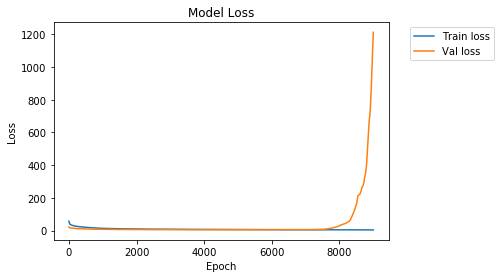

In [29]:
#Plot model loss

w = 1000
h1 = np.array(history.history['loss'])
h4 = np.array(history.history['val_loss'])
h1 = moving_average(h1,w)
h4 = moving_average(h4,w)
plt.plot(h1,label='Train loss')
plt.plot(h4,label='Val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

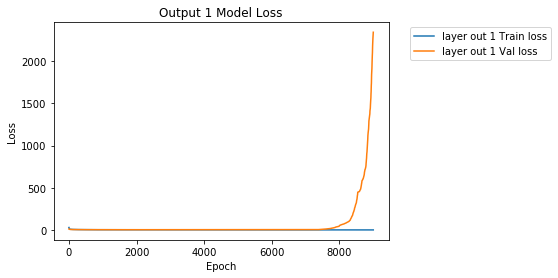

In [30]:
#Plot output 1 loss

h2 = np.array(history.history['out1_loss'])
h5 = np.array(history.history['val_out1_loss'])
h2 = moving_average(h2,w)
h5 = moving_average(h5,w)
plt.plot(h2,label='layer out 1 Train loss')
plt.plot(h5,label='layer out 1 Val loss')
plt.title('Output 1 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

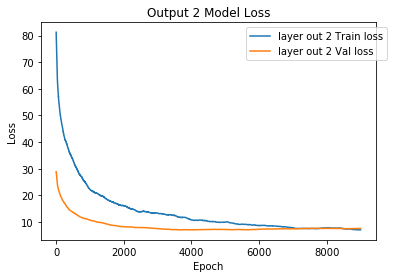

In [31]:
#Plot output 2 loss

h3 = np.array(history.history['out2_loss'])
h6 = np.array(history.history['val_out2_loss'])
h3 = moving_average(h3,w)
h6 = moving_average(h6,w)
plt.plot(h3,label='layer out 2 Train loss')
plt.plot(h6,label='layer out 2 Val loss')
plt.title('Output 2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

In [26]:
#Load ground truth RUL

thr = mat['thr']
fleet_NUM = np.arange(0,pad,1)

rul = pd.read_csv(rul_file,index_col=False)
rul = (rul-1)/(thr-1)
rul_Fleet_All = np.zeros(100)
for x in range(100):
    rul_Fleet_All[x] = rul['RUL'][x]
rul_Fleet_All_Full = ((thr-1)*rul_Fleet_All) + 1
rul_Fleet_All_Full

array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 28., 50., 16., 50., 50., 50., 20., 50., 50.,
       50., 50., 50., 50.,  8., 48., 50.,  7., 11., 19., 21., 50., 50.,
       28., 18., 10., 50., 50., 50., 47., 50., 50., 21., 50., 50., 29.,
       26., 50., 50., 15., 50., 37., 50., 50., 21., 50., 50., 28., 50.,
       14., 50.,  8., 50., 50., 50., 50., 50., 50., 50., 10., 34., 50.,
       50., 50.,  8.,  9., 50., 50., 50., 50., 50., 50., 50., 28., 38.,
       20., 50., 50., 50., 50., 50., 50., 50., 20.])

In [27]:
#Make 100 predictions and calculate average RMSE & Score

import sklearn
import math
from sklearn import metrics

rmse = np.zeros(100)
rmse1 = np.zeros(100)
sc = np.zeros(100)
sc1 = np.zeros(100)

for i in range(100):
    
    preds = model(x_test)
    tens_draw = preds[0].sample(1000)
    tens_draw1 = preds[1].sample(1000)
    tens_draw = tf.keras.backend.get_value(tens_draw)
    tens_draw1 = tf.keras.backend.get_value(tens_draw1)

    #RMSE with AU

    mean_Fleet_All = np.zeros(tens_draw.shape[1])
    mean_Fleet = np.zeros(tens_draw.shape[0])
    for y in range(tens_draw.shape[1]):
        for x in range(tens_draw.shape[0]):
            mean_Fleet[x] = tens_draw[x,y,0]
        mean_Fleet_All[y] = mean_Fleet.mean()

    RUL_mse = sklearn.metrics.mean_squared_error(rul_Fleet_All_Full, mean_Fleet_All)
    RUL_rmse = math.sqrt(RUL_mse)
    rmse[i] = RUL_rmse

    #RMSE with EU

    mean_Fleet_All1 = np.zeros(tens_draw1.shape[1])
    mean_Fleet1 = np.zeros(tens_draw1.shape[0])
    for y in range(tens_draw1.shape[1]):
        for x in range(tens_draw1.shape[0]):
            mean_Fleet1[x] = tens_draw1[x,y,0]
        mean_Fleet_All1[y] = mean_Fleet1.mean()

    RUL_mse1 = sklearn.metrics.mean_squared_error(rul_Fleet_All_Full, mean_Fleet_All1)
    RUL_rmse1 = math.sqrt(RUL_mse1)
    rmse1[i] = RUL_rmse1
    
    score = mean_Fleet_All-rul_Fleet_All_Full

    for j in range(100):
        if score[j]<0:
            score[j]= math.exp((-score[j])/13)-1
        else:
            score[j] = math.exp(score[j]/10)-1
    
    sc[i] = np.sum(score)
    
    score1 = mean_Fleet_All1-rul_Fleet_All_Full

    for j in range(100):
        if score1[j]<0:
            score1[j]= math.exp((-score1[j])/13)-1
        else:
            score1[j] = math.exp(score1[j]/10)-1
    
    sc1[i] = np.sum(score1)

In [28]:
#Average RMSE with AU & EU
np.mean(rmse),np.mean(rmse1)

(17.937537577560164, 18.465243860835912)

In [29]:
#Average early prediction Score with AU & EU
np.mean(sc),np.mean(sc1)

(1025.3156050205403, 1231.1033327043235)

In [30]:
#Calculate Mean & Std of prediction with AU

Fleet = pd.DataFrame(np.zeros((pad,tens_draw.shape[0])))
mean = pd.DataFrame(np.zeros((pad,1)))
std = pd.DataFrame(np.zeros((pad,1)))
for y in range(tens_draw1.shape[0]):
    Fleet[y] = tens_draw[y][0]
    row_Mean = Fleet.mean(axis=1)
    row_Std = Fleet.std(axis=1)
    for j in range(pad):
        mean[0][j] = row_Mean[j]
    for k in range(pad):
        std[0][k] = row_Std[k]

In [31]:
#Calculate Mean & Std of prediction with EU

Fleet1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[0])))
mean1 = pd.DataFrame(np.zeros((pad,1)))
std1 = pd.DataFrame(np.zeros((pad,1)))
for y in range(tens_draw1.shape[0]):
    Fleet1[y] = tens_draw1[y][0]
    row_Mean = Fleet1.mean(axis=1)
    row_Std = Fleet1.std(axis=1)
    for j in range(pad):
        mean1[0][j] = row_Mean[j]
    for k in range(pad):
        std1[0][k] = row_Std[k]

In [32]:
#Load ground truth RUL

fleet_RUL = pd.read_csv(fleet_Rul_File, skiprows = 0,header = None)

In [33]:
max_RUL_Arrange = pd.DataFrame(np.zeros((100,2)))
for x in range(100):
    max_RUL_Arrange[0][x] = fleet_NUM[x]
    max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[0][x]) + 1
max_RUL_Arrange.columns = ['Cycle','RUL']

Using matplotlib backend: Qt5Agg


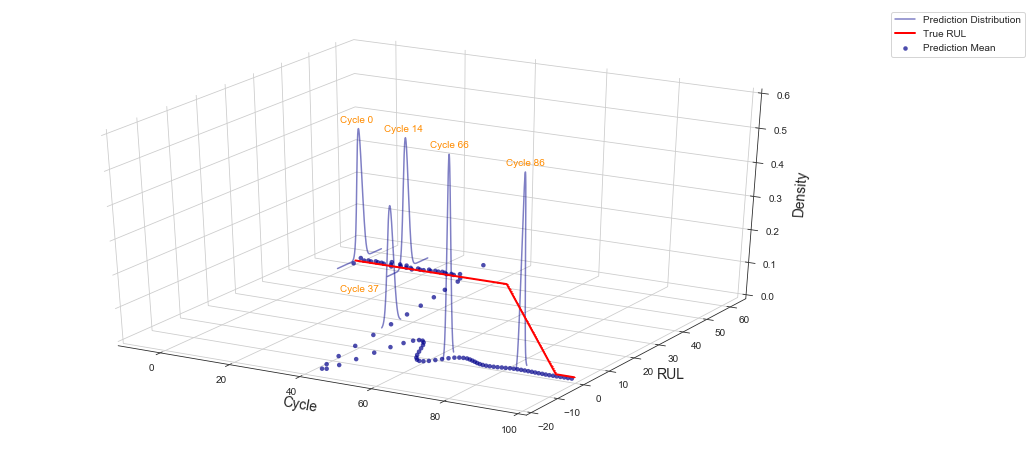

In [71]:
#3d visualization of prediction
%matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
from scipy.stats import norm

sns.set_style('ticks')

%matplotlib inline
plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-10, 100)
ax.set_ylim3d(-20, 65)
ax.set_zlim3d(0, 0.6)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_xlabel('Cycle',fontsize='14')
ax.set_ylabel('RUL',fontsize='14')
ax.set_zlabel('Density',fontsize='14')

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


s = np.arange(0,100,1)

i = 0
Fleetx = Fleet.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.scatter3D(np.full((1000,),i),Fleetx,0,color = 'black',marker=".",alpha=0.01,label = "Prediction")
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean[0][i]),color = 'darkblue', label = "Prediction Distribution", alpha=0.5)

i = 15
Fleetx = Fleet.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.scatter3D(np.full((1000,),i),Fleetx,0,color = 'black',marker=".",alpha=0.01)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean[0][i]),color = 'darkblue', alpha=0.5)

i = 38
Fleetx = Fleet.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.scatter3D(np.full((1000,),i),Fleetx,0,color = 'black',marker=".",alpha=0.01)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean[0][i],std[0][i]),color = 'darkblue',alpha=0.5)

i = 65
Fleetx = Fleet.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.scatter3D(np.full((1000,),i),Fleetx,0,color = 'black',marker=".",alpha=0.01)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean[0][i],std[0][i]),color = 'darkblue',alpha=0.5)

i = 85
Fleetx = Fleet.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.scatter3D(np.full((1000,),i),Fleetx,0,color = 'black',marker=".",alpha=0.01)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean[0][i],std[0][i]),color = 'darkblue',alpha=0.5)

ax.scatter3D(s,mean[0][0:100],linewidth=0.03,marker="o",color = "darkblue", alpha=0.7,label='Prediction Mean')
ax.plot3D(s,max_RUL_Arrange['RUL'],linewidth=2,marker="_",markersize=1,color = 'r',label='True RUL')

ax.text(-0.5, 46, 0.435, "Cycle 0", color='darkorange')
ax.text(13, 45, 0.43, "Cycle 14", color='darkorange')
ax.text(15, 25, 0.02, "Cycle 37", color='darkorange')
ax.text(60, 0, 0.60, "Cycle 66", color='darkorange')
ax.text(80, 0, 0.58, "Cycle 86", color='darkorange')

plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
#ax.view_init(0, 45)
plt.show()

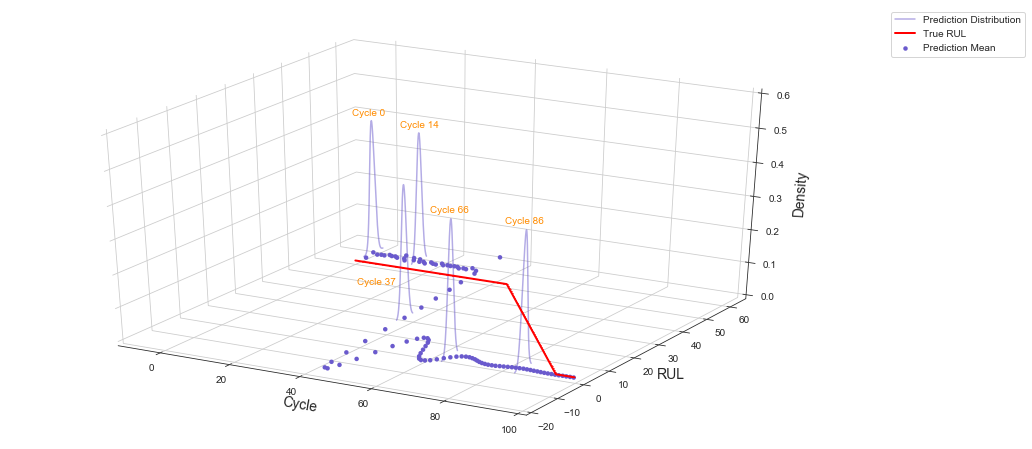

In [96]:
sns.set_style('ticks')

%matplotlib inline
plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d')
ax.set_xlim3d(-10, 100)
ax.set_ylim3d(-20, 65)
ax.set_zlim3d(0, 0.6)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_xlabel('Cycle',fontsize='14')
ax.set_ylabel('RUL',fontsize='14')
ax.set_zlabel('Density',fontsize='14')

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

s = np.arange(0,100,1)

i = 0
Fleetx = Fleet1.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.plot3D(np.full((1000,),i),Fleetx,0,color = 'coral',marker=".",markersize=0.35,label='Prediction')
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean1[0][i],std1[0][i]),color = 'slateblue', alpha=0.5, label="Prediction Distribution")

i = 15
Fleetx = Fleet1.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.plot3D(np.full((1000,),i),Fleetx,0,color = 'coral',marker=".",markersize=0.35)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean1[0][i],std1[0][i]),color = 'slateblue', alpha=0.5)

i = 38
Fleetx = Fleet1.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.plot3D(np.full((1000,),i),Fleetx,0,color = 'coral',marker=".",markersize=0.35)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean1[0][i],std1[0][i]),color = 'slateblue', alpha=0.5)

i = 65
Fleetx = Fleet1.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.plot3D(np.full((1000,),i),Fleetx,0,color = 'coral',marker=".",markersize=0.35)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean1[0][i],std1[0][i]),color = 'slateblue', alpha=0.5)

i = 85
Fleetx = Fleet1.iloc[i:i+1,:].to_numpy().reshape(1000,)
mindist = Fleetx.min()
maxdist = Fleetx.max()
y = np.linspace(mindist,maxdist,1000)
#ax.plot3D(np.full((1000,),i),Fleetx,0,color = 'coral',marker=".",markersize=0.35)
ax.plot3D(np.full((1000,),i),y,stats.norm.pdf(y,mean1[0][i],std1[0][i]),color = 'slateblue', alpha=0.5)

ax.scatter3D(s,mean1[0][0:100],linewidth=0.03,marker="o",color = 'slateblue',alpha=1,label='Prediction Mean')
ax.plot3D(s,max_RUL_Arrange['RUL'],linewidth=2,marker="_",markersize=1,color = 'r',label='True RUL')

ax.text(3, 46, 0.46, "Cycle 0", color='darkorange')
ax.text(17.5, 45, 0.45, "Cycle 14", color='darkorange')
ax.text(20, 25, 0.05, "Cycle 37", color='darkorange')
ax.text(60, 0, 0.42, "Cycle 66", color='darkorange')
ax.text(80, 0, 0.42, "Cycle 86", color='darkorange')

plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.show()

In [97]:
#Define cycle when RUL ground truth become 0

cycle_lim = np.zeros(100)
S = 0
for K in range(100):
    for L in range(pad):
        if fleet_RUL[K][L] == 0:
            S = 0
            break
        else:
            S = S + 1
            cycle_lim[K] = S

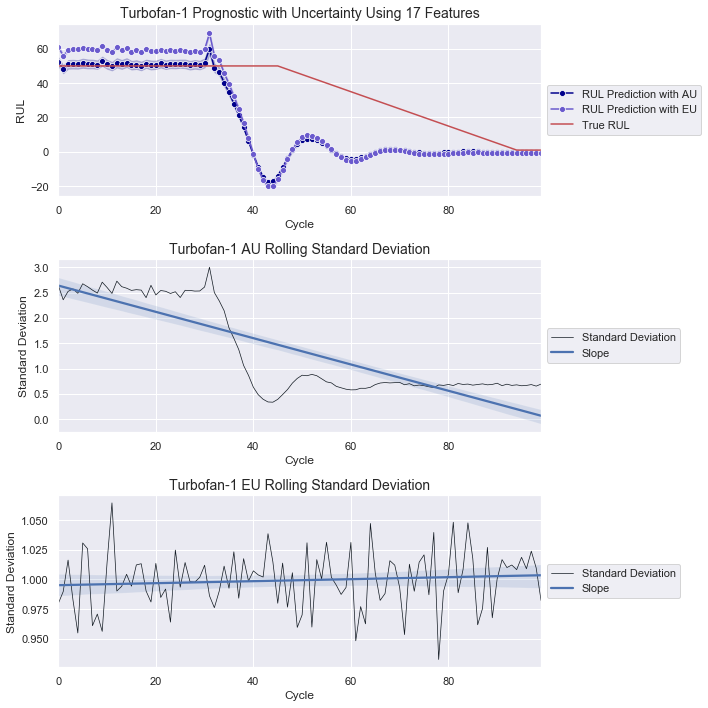

In [43]:
#Visualization Fleet 1

import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats
sns.set()
for B in range(0,1):
    lim = 100#int(cycle_lim[B]+1)
    lim2 = 100#int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','RUL']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','RUL']
    
    max_Seq_Arrange1.columns = ['Cycle','RUL']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std[0][x]
    min_Std_Arrange.columns = ['Cycle','RUL']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std1[0][x]
    med_Std_Arrange.columns = ['Cycle','RUL']
    
    #get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange, color='darkblue',ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange1, color='slateblue',ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="RUL", data = max_RUL_Arrange, color='r', ax=ax,label="True RUL")
    plt.title('Turbofan-%i Prognostic with Uncertainty Using 17 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'RUL', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'],scatter = False,label='Slope')
    plt.title('Turbofan-%i AU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'RUL', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['RUL'],scatter = False,label='Slope')
    plt.title('Turbofan-%i EU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("Fleet %i Pred" %B+'.jpg')
    plt.tight_layout()
    plt.show()

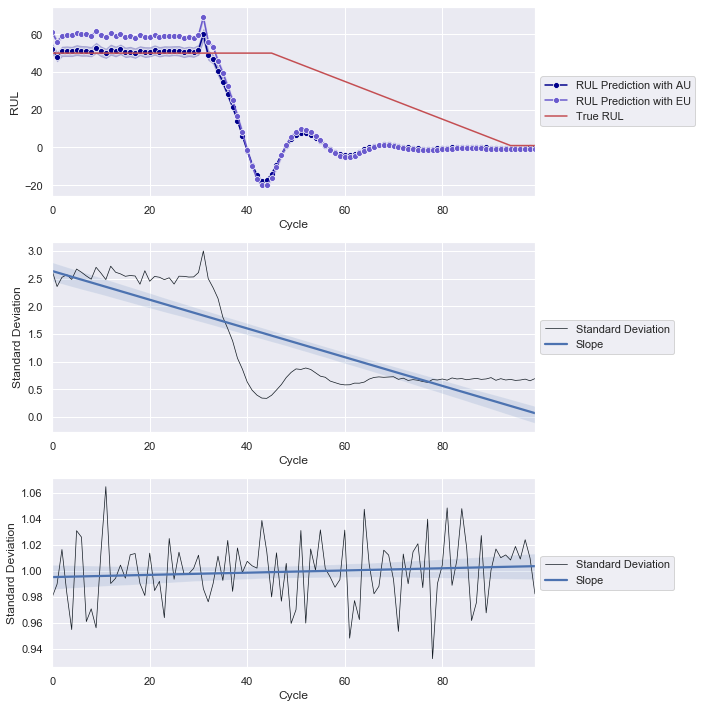

In [44]:
#Visualization Fleet 1

import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats
sns.set()
for B in range(0,1):
    lim = 100#int(cycle_lim[B]+1)
    lim2 = 100#int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','RUL']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','RUL']
    
    max_Seq_Arrange1.columns = ['Cycle','RUL']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std[0][x]
    min_Std_Arrange.columns = ['Cycle','RUL']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std1[0][x]
    med_Std_Arrange.columns = ['Cycle','RUL']
    
    #get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange, color='darkblue',ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange1, color='slateblue',ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="RUL", data = max_RUL_Arrange, color='r', ax=ax,label="True RUL")
    #plt.title('Turbofan-%i Prognostic with Uncertainty Using 17 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'RUL', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'],scatter = False,label='Slope')
    #plt.title('Turbofan-%i AU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'RUL', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['RUL'],scatter = False,label='Slope')
    #plt.title('Turbofan-%i EU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("Fleet %i Pred" %B+'.jpg')
    plt.tight_layout()
    plt.show()

In [98]:
#Calculate Mean & Std of prediction Turbofan 18 with AU

Fleet3 = pd.DataFrame(np.zeros((pad,tens_draw.shape[0])))
mean3 = pd.DataFrame(np.zeros((pad,tens_draw.shape[1])))
std3 = pd.DataFrame(np.zeros((pad,tens_draw.shape[1])))
for y in range(1000):
    Fleet3[y] = tens_draw[y][17]
    row_Mean = Fleet3.mean(axis=1)
    row_Std = Fleet3.std(axis=1)
    for j in range(pad):
        mean3[0][j] = row_Mean[j]
    for k in range(pad):
        std3[0][k] = row_Std[k]

In [99]:
#Calculate Mean & Std of prediction Turbofan 18 with EU

Fleet4 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[0])))
mean4 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[1])))
std4 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[1])))
for y in range(tens_draw1.shape[0]):
    Fleet4[y] = tens_draw1[y][17]
    row_Mean = Fleet4.mean(axis=1)
    row_Std = Fleet4.std(axis=1)
    for j in range(pad):
        mean4[0][j] = row_Mean[j]
    for k in range(pad):
        std4[0][k] = row_Std[k]

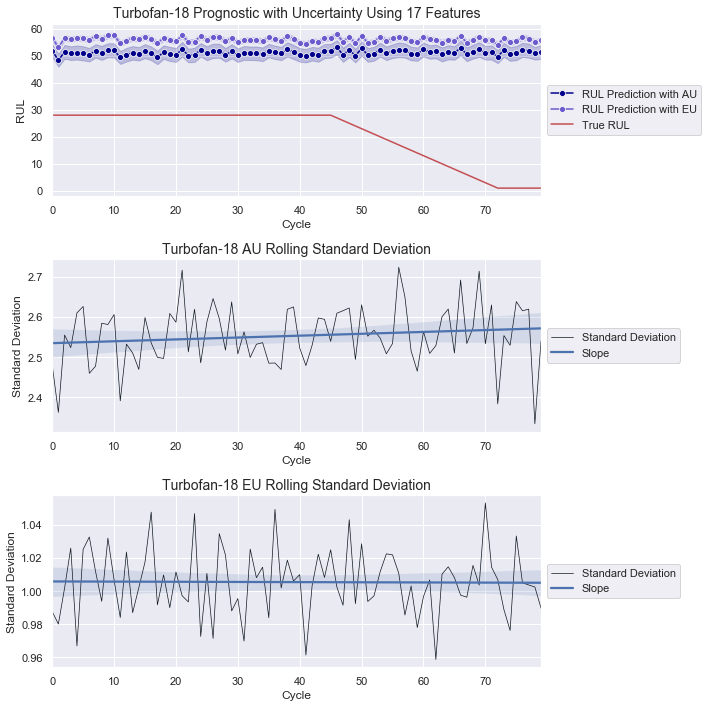

In [103]:
#Visualization Fleet 18
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats

sns.set()
for B in range(17,18):
    lim = 80#int(cycle_lim[B]+1)
    lim2 = 80#int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','RUL']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','RUL']
    
    max_Seq_Arrange1.columns = ['Cycle','RUL']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std3[0][x]
    min_Std_Arrange.columns = ['Cycle','RUL']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std4[0][x]
    med_Std_Arrange.columns = ['Cycle','RUL']
    
    #get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange, color='darkblue',ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange1, color='slateblue',ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="RUL", data = max_RUL_Arrange, color='r', ax=ax,label="True RUL")
    plt.title('Turbofan-%i Prognostic with Uncertainty Using 17 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'RUL', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'],scatter = False,label='Slope')
    plt.title('Turbofan-%i AU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'RUL', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['RUL'],scatter = False,label='Slope')
    plt.title('Turbofan-%i EU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

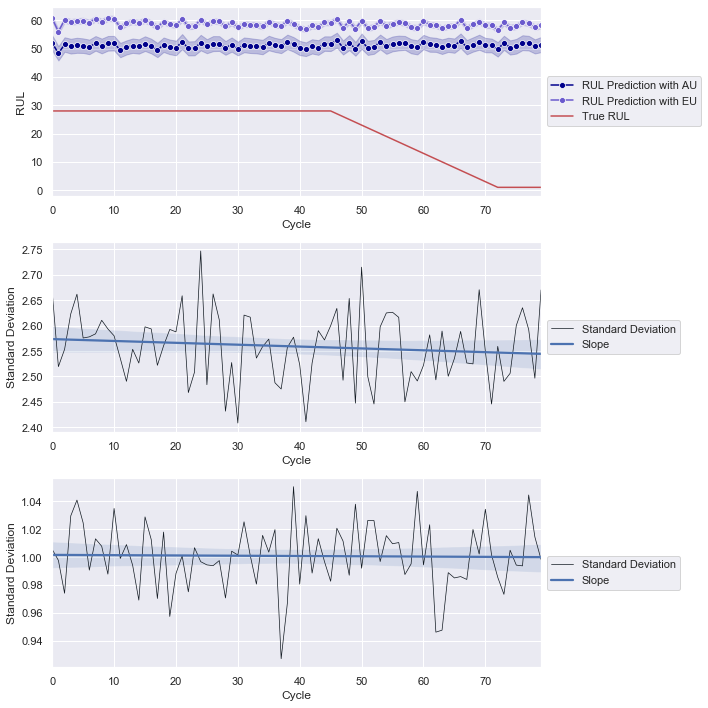

In [48]:
#Visualization Fleet 18

sns.set()
for B in range(17,18):
    lim = 80#int(cycle_lim[B]+1)
    lim2 = 80#int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','RUL']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','RUL']
    
    max_Seq_Arrange1.columns = ['Cycle','RUL']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std3[0][x]
    min_Std_Arrange.columns = ['Cycle','RUL']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std4[0][x]
    med_Std_Arrange.columns = ['Cycle','RUL']
    
    #get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange, color='darkblue',ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="RUL",ci = "sd", marker='o', data=max_Seq_Arrange1, color='slateblue',ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="RUL", data = max_RUL_Arrange, color='r', ax=ax,label="True RUL")
    #plt.title('Turbofan-%i Prognostic with Uncertainty Using 17 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'RUL', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['RUL'],scatter = False,label='Slope')
    #plt.title('Turbofan-%i AU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'RUL', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['RUL'],scatter = False,label='Slope')
    #plt.title('Turbofan-%i EU Rolling Standard Deviation' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

In [26]:
#SHAP cannot be used with model with probabilistic layers. So, transfer learned weights of probabilistic LSTM to a new LSTM without probabilistic layers
#Define New LSTM without probabilistic layers for explanation

inputs = tf.keras.Input(shape=(303,17),dtype='float32')
layer1 = LSTM(unit1,return_sequences = True)(inputs)
layer2 = Dense(size1)(layer1)
layer3 = Dense(1)(layer2)
layer4 = Lambda(lambda t: t[:,-1],name='out2')(layer3)
model2 = tf.keras.Model(inputs=inputs, outputs=layer4)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 303, 17)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 303, 64)           20992     
_________________________________________________________________
dense_2 (Dense)              (None, 303, 364)          23660     
_________________________________________________________________
dense_3 (Dense)              (None, 303, 1)            365       
_________________________________________________________________
out2 (Lambda)                (None, 1)                 0         
Total params: 45,017
Trainable params: 45,017
Non-trainable params: 0
_________________________________________________________________


In [27]:
a = model.layers[3].get_weights()

b = np.zeros((len(a[0]),1))
for x in range(len(a[0])):
    b[x] = a[0][x][0]
    
d = np.zeros(1)
for x in range(1):
    d[x] = a[1][x]
    
c = [b,d]

In [28]:
#Transfer weights from old LSTM to new LSTM

model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[1].set_weights(model.layers[1].get_weights())
model2.layers[2].set_weights(model.layers[2].get_weights())
model2.layers[3].set_weights(c)

In [52]:
#Prediction with new LSTM

preds2 = model2(x_test)
y3 = preds2
y3 = tf.keras.backend.get_value(y3)
tens_draw3 = y3

In [53]:
#Import SHAP & initialized JS

import shap
shap.initjs()

In [54]:
#Extract Feature Names

features = pd.read_csv(train_file, index_col=False)
features = features.drop(['Fleet','Cycle','RUL'],axis=1)
features = np.array(list(features.columns))
features

array(['OC1', 'OC2', 'OC3', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11',
       'S12', 'S13', 'S14', 'S15', 'S17', 'S20', 'S21'], dtype='<U3')

In [55]:
#load Training Files into Pandas Dataframes for SHAP Plots

xtrain = pd.read_csv(train_file, index_col=False)
xtrain = xtrain.drop(['Fleet','Cycle','RUL'],axis=1)

In [56]:
#SHAP Summmary Plot

instance = x_train
instance2 = x_test
explainer = shap.DeepExplainer(model2,instance)
shap_values = explainer.shap_values(instance2)

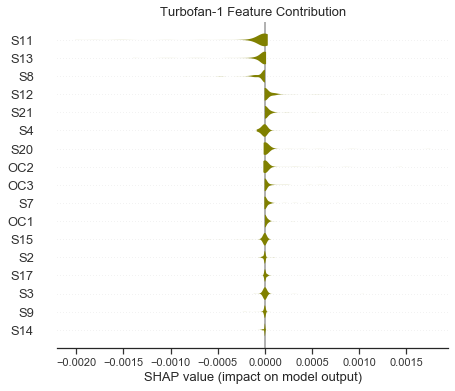

In [57]:
# SHAP Summmary Plot Turbofan 1

sns.set_style("ticks")
for i in range(0,1):
    shap.summary_plot(shap_values[0][i],feature_names=xtrain.columns,show=False,plot_size=(7,6),plot_type="violin", color='olive')
    plt.title("Turbofan-%i Feature Contribution" %(i+1),fontsize=13)
    #plt.savefig("Sum_Plot %i" %i+'.png')
    #plt.figure

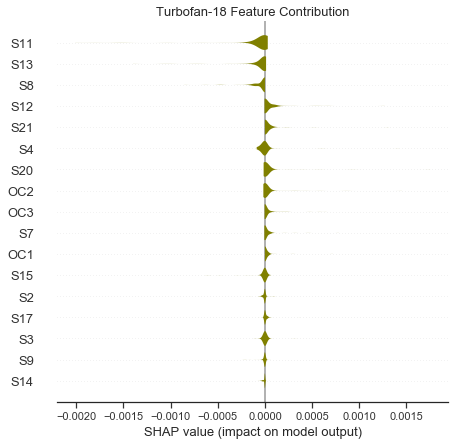

In [58]:
# SHAP Summmary Plot Turbofan 18

for i in range(17,18):
    shap.summary_plot(shap_values[0][i],feature_names=xtrain.columns,show=False,plot_size=(7,7),plot_type="violin", color='olive')
    plt.title("Turbofan-%i Feature Contribution" %(i+1),fontsize=13)

In [59]:
#SHAP Force Plot Turbofan 1

sns.set_style('ticks')
instance2 = x_train
explainer = shap.DeepExplainer(model2,instance2)
for s in range(0,1):
    instance=x_test[s:s+1]
    shap_values = explainer.shap_values(instance)
    e = explainer.expected_value
    #Per individual array 
    for j in range(303):
        print(s+1,j+1)
        xtest_df = pd.DataFrame(data = x_test[s][j].reshape(1,17),columns=features).round(3)
        shap_display = shap.force_plot(e[0],shap_values[0][0][j],xtest_df,matplotlib = False,show = False,figsize=(10, 2))
        display(shap_display)

1 1


1 2


1 3


1 4


1 5


1 6


1 7


1 8


1 9


1 10


1 11


1 12


1 13


1 14


1 15


1 16


1 17


1 18


1 19


1 20


1 21


1 22


1 23


1 24


1 25


1 26


1 27


1 28


1 29


1 30


1 31


1 32


1 33


1 34


1 35


1 36


1 37


1 38


1 39


1 40


1 41


1 42


1 43


1 44


1 45


1 46


1 47


1 48


1 49


1 50


1 51


1 52


1 53


1 54


1 55


1 56


1 57


1 58


1 59


1 60


1 61


1 62


1 63


1 64


1 65


1 66


1 67


1 68


1 69


1 70


1 71


1 72


1 73


1 74


1 75


1 76


1 77


1 78


1 79


1 80


1 81


1 82


1 83


1 84


1 85


1 86


1 87


1 88


1 89


1 90


1 91


1 92


1 93


1 94


1 95


1 96


1 97


1 98


1 99


1 100


1 101


1 102


1 103


1 104


1 105


1 106


1 107


1 108


1 109


1 110


1 111


1 112


1 113


1 114


1 115


1 116


1 117


1 118


1 119


1 120


1 121


1 122


1 123


1 124


1 125


1 126


1 127


1 128


1 129


1 130


1 131


1 132


1 133


1 134


1 135


1 136


1 137


1 138


1 139


1 140


1 141


1 142


1 143


1 144


1 145


1 146


1 147


1 148


1 149


1 150


1 151


1 152


1 153


1 154


1 155


1 156


1 157


1 158


1 159


1 160


1 161


1 162


1 163


1 164


1 165


1 166


1 167


1 168


1 169


1 170


1 171


1 172


1 173


1 174


1 175


1 176


1 177


1 178


1 179


1 180


1 181


1 182


1 183


1 184


1 185


1 186


1 187


1 188


1 189


1 190


1 191


1 192


1 193


1 194


1 195


1 196


1 197


1 198


1 199


1 200


1 201


1 202


1 203


1 204


1 205


1 206


1 207


1 208


1 209


1 210


1 211


1 212


1 213


1 214


1 215


1 216


1 217


1 218


1 219


1 220


1 221


1 222


1 223


1 224


1 225


1 226


1 227


1 228


1 229


1 230


1 231


1 232


1 233


1 234


1 235


1 236


1 237


1 238


1 239


1 240


1 241


1 242


1 243


1 244


1 245


1 246


1 247


1 248


1 249


1 250


1 251


1 252


1 253


1 254


1 255


1 256


1 257


1 258


1 259


1 260


1 261


1 262


1 263


1 264


1 265


1 266


1 267


1 268


1 269


1 270


1 271


1 272


1 273


1 274


1 275


1 276


1 277


1 278


1 279


1 280


1 281


1 282


1 283


1 284


1 285


1 286


1 287


1 288


1 289


1 290


1 291


1 292


1 293


1 294


1 295


1 296


1 297


1 298


1 299


1 300


1 301


1 302


1 303


In [60]:
#SHAP Force Plot Turbofan 18

for s in range(17,18):
    instance=x_test[s:s+1]
    shap_values = explainer.shap_values(instance)
    e = explainer.expected_value
    #Per individual array 
    for j in range(303):
        print(s+1,j+1)
        xtest_df = pd.DataFrame(data = x_test[s][j].reshape(1,17),columns=features).round(3)
        shap_display = shap.force_plot(e[0],shap_values[0][0][j],xtest_df,matplotlib = False,show = False,figsize=(10, 2))
        display(shap_display)

18 1


18 2


18 3


18 4


18 5


18 6


18 7


18 8


18 9


18 10


18 11


18 12


18 13


18 14


18 15


18 16


18 17


18 18


18 19


18 20


18 21


18 22


18 23


18 24


18 25


18 26


18 27


18 28


18 29


18 30


18 31


18 32


18 33


18 34


18 35


18 36


18 37


18 38


18 39


18 40


18 41


18 42


18 43


18 44


18 45


18 46


18 47


18 48


18 49


18 50


18 51


18 52


18 53


18 54


18 55


18 56


18 57


18 58


18 59


18 60


18 61


18 62


18 63


18 64


18 65


18 66


18 67


18 68


18 69


18 70


18 71


18 72


18 73


18 74


18 75


18 76


18 77


18 78


18 79


18 80


18 81


18 82


18 83


18 84


18 85


18 86


18 87


18 88


18 89


18 90


18 91


18 92


18 93


18 94


18 95


18 96


18 97


18 98


18 99


18 100


18 101


18 102


18 103


18 104


18 105


18 106


18 107


18 108


18 109


18 110


18 111


18 112


18 113


18 114


18 115


18 116


18 117


18 118


18 119


18 120


18 121


18 122


18 123


18 124


18 125


18 126


18 127


18 128


18 129


18 130


18 131


18 132


18 133


18 134


18 135


18 136


18 137


18 138


18 139


18 140


18 141


18 142


18 143


18 144


18 145


18 146


18 147


18 148


18 149


18 150


18 151


18 152


18 153


18 154


18 155


18 156


18 157


18 158


18 159


18 160


18 161


18 162


18 163


18 164


18 165


18 166


18 167


18 168


18 169


18 170


18 171


18 172


18 173


18 174


18 175


18 176


18 177


18 178


18 179


18 180


18 181


18 182


18 183


18 184


18 185


18 186


18 187


18 188


18 189


18 190


18 191


18 192


18 193


18 194


18 195


18 196


18 197


18 198


18 199


18 200


18 201


18 202


18 203


18 204


18 205


18 206


18 207


18 208


18 209


18 210


18 211


18 212


18 213


18 214


18 215


18 216


18 217


18 218


18 219


18 220


18 221


18 222


18 223


18 224


18 225


18 226


18 227


18 228


18 229


18 230


18 231


18 232


18 233


18 234


18 235


18 236


18 237


18 238


18 239


18 240


18 241


18 242


18 243


18 244


18 245


18 246


18 247


18 248


18 249


18 250


18 251


18 252


18 253


18 254


18 255


18 256


18 257


18 258


18 259


18 260


18 261


18 262


18 263


18 264


18 265


18 266


18 267


18 268


18 269


18 270


18 271


18 272


18 273


18 274


18 275


18 276


18 277


18 278


18 279


18 280


18 281


18 282


18 283


18 284


18 285


18 286


18 287


18 288


18 289


18 290


18 291


18 292


18 293


18 294


18 295


18 296


18 297


18 298


18 299


18 300


18 301


18 302


18 303
